<a href="https://colab.research.google.com/github/chuducthang77/Machine-Learning-tutorials-and-notes/blob/main/7_OD%2COS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

## Installation

In [1]:
%cd /content/drive/MyDrive/NEU/HW/

/content/drive/MyDrive/NEU/HW


In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt # install

import torch
import utils
display = utils.notebook_init()  # checks
%cd ..

YOLOv5 🚀 v7.0-428-ge61d8fd Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.8/78.2 GB disk)
/content/drive/MyDrive/NEU/HW


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import cv2

%matplotlib inline

## Dataset: Extended MNIST

- Training set: 55000 examples
  - Train X: 55000 images with a shape (64, 64, 3)
  - Train Y: Labels of 2 digits (i.e 1 or 9) for each image
  - Train bounding boxes: Bounding boxes of 2 digit for each image

In [ ]:
train_X = np.load('./Solutions/data/train_X.npy')
train_Y = np.load('./Solutions/data/train_Y.npy')
train_bboxes = np.load('./Solutions/data/train_bboxes.npy')

In [ ]:
print('Shape of train_X: ', train_X.shape)
print('Shape of train_Y: ', train_Y.shape)
print('Shape of train bounding boxes: ', train_bboxes.shape)

Shape of train_X:  (55000, 12288)
Shape of train_Y:  (55000, 2)
Shape of train bounding boxes:  (55000, 2, 4)


In [ ]:
# Print the first image and its bounding boxes
first_X = np.reshape(train_X[0], (64, 64, 3))
first_Y = train_Y[0]
first_bboxes = train_bboxes[0]

print('2 labels of the first image: ', first_Y)
print('2 bounding boxes of the first image: \n', first_bboxes)

ymin1, xmin1, ymax1, xmax1 = first_bboxes[0]
ymin2, xmin2, ymax2, xmax2 = first_bboxes[1]

2 labels of the first image:  [3 7]
2 bounding boxes of the first image: 
 [[11  9 39 37]
 [ 6 23 34 51]]


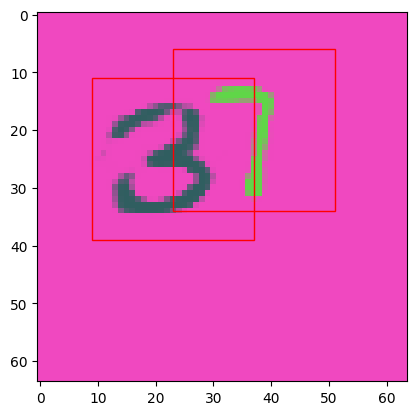

In [ ]:
fig, ax = plt.subplots()
ax.imshow(first_X)
rect_1 = patches.Rectangle((xmin1, ymin1), 28, 28, edgecolor='r', facecolor='none')
rect_2 = patches.Rectangle((xmin2, ymin2), 28, 28, edgecolor='r', facecolor='none')
ax.add_patch(rect_1)
ax.add_patch(rect_2)
plt.show()

## Model: Yolov5s

For this task we will use [YOLOV5](https://github.com/ultralytics/yolov5) model. We need some modifications on this code to work.


### Step 1: .npy data

Concatenate the label with the modified bounding boxes

### Why numpy?

There are 50000 training images so if we train Yolov5 model in Colab directly on these images, we will face with the bottleneck issue.



In [ ]:
# Load the train set
train_X = np.load("./Solutions/data/train_X.npy")
train_Y = np.load("./Solutions/data/train_Y.npy")
train_bboxes = np.load("./Solutions/data/train_bboxes.npy")
modified_train_bboxes = np.copy(train_bboxes)

# Change the format from (y_min, x_min, y_max, x_max) to (x_center, y_center, width, height)
modified_train_bboxes[:, :, 0] = (train_bboxes[:, :, 1] + (train_bboxes[:, :, 3] - train_bboxes[:, :, 1])/2)
modified_train_bboxes[:, :, 1] = (train_bboxes[:, :, 0] + (train_bboxes[:, :, 2] - train_bboxes[:, :, 0])/2)
modified_train_bboxes[:, :, 2] = (train_bboxes[:, :, 3] - train_bboxes[:, :, 1])
modified_train_bboxes[:, :, 3] = (train_bboxes[:, :, 2] - train_bboxes[:, :, 0])

# Change the scale to 0-1
modified_train_bboxes = modified_train_bboxes / 64

# Concatenate the label
train_Y = train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1)
train_Y = np.concatenate((train_Y, modified_train_bboxes), axis=2)

# Save the numpy file
np.save('./datasets/custom/images/train/train_X.npy', train_X)
np.save('./datasets/custom/labels/train/train_Y.npy',train_Y)


# Load the validation file
valid_X = np.load("./Solutions/data/valid_X.npy")
valid_Y = np.load("./Solutions/data/valid_Y.npy")
valid_bboxes = np.load("./Solutions/data/valid_bboxes.npy")
modified_valid_bboxes = np.copy(valid_bboxes)

# Change the format from (y_min, x_min, y_max, x_max) to (x_center, y_center, width, height)
modified_valid_bboxes[:, :, 0] = (valid_bboxes[:, :, 1] + (valid_bboxes[:, :, 3] - valid_bboxes[:, :, 1])/2)
modified_valid_bboxes[:, :, 1] = (valid_bboxes[:, :, 0] + (valid_bboxes[:, :, 2] - valid_bboxes[:, :, 0])/2)
modified_valid_bboxes[:, :, 2] = (valid_bboxes[:, :, 3] - valid_bboxes[:, :, 1])
modified_valid_bboxes[:, :, 3] = (valid_bboxes[:, :, 2] - valid_bboxes[:, :, 0])

# Change the scale to 0-1
modified_valid_bboxes = modified_valid_bboxes / 64

# Concatenate the label
valid_Y = valid_Y.reshape(valid_Y.shape[0], valid_Y.shape[1], 1)
valid_Y = np.concatenate((valid_Y, modified_valid_bboxes), axis=2)


# Save the numpy file
np.save('./datasets/custom/images/valid/valid_X.npy', valid_X)
np.save('./datasets/custom/labels/valid/valid_Y.npy',valid_Y)

### Step 2: Datasets directory

Create the "datasets" folder and put the .npy files as the following structure.

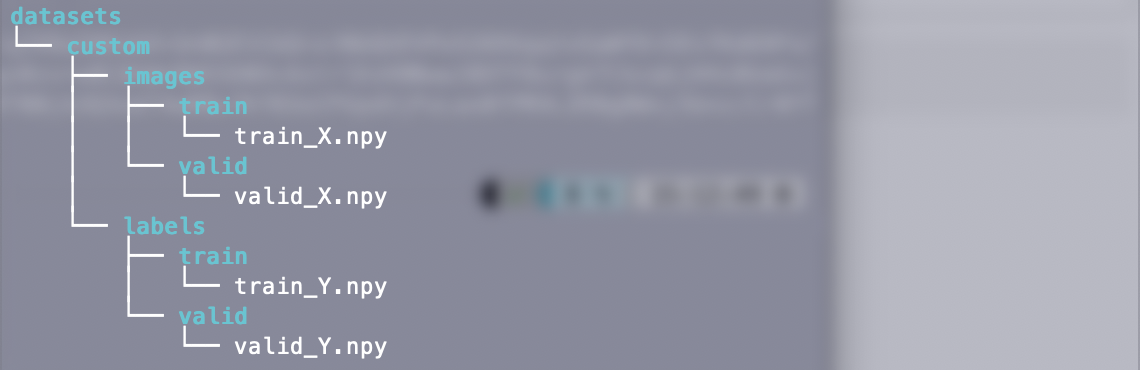


### Step 3: YAML

Create the custom.yaml and put it into yolov5/data folder
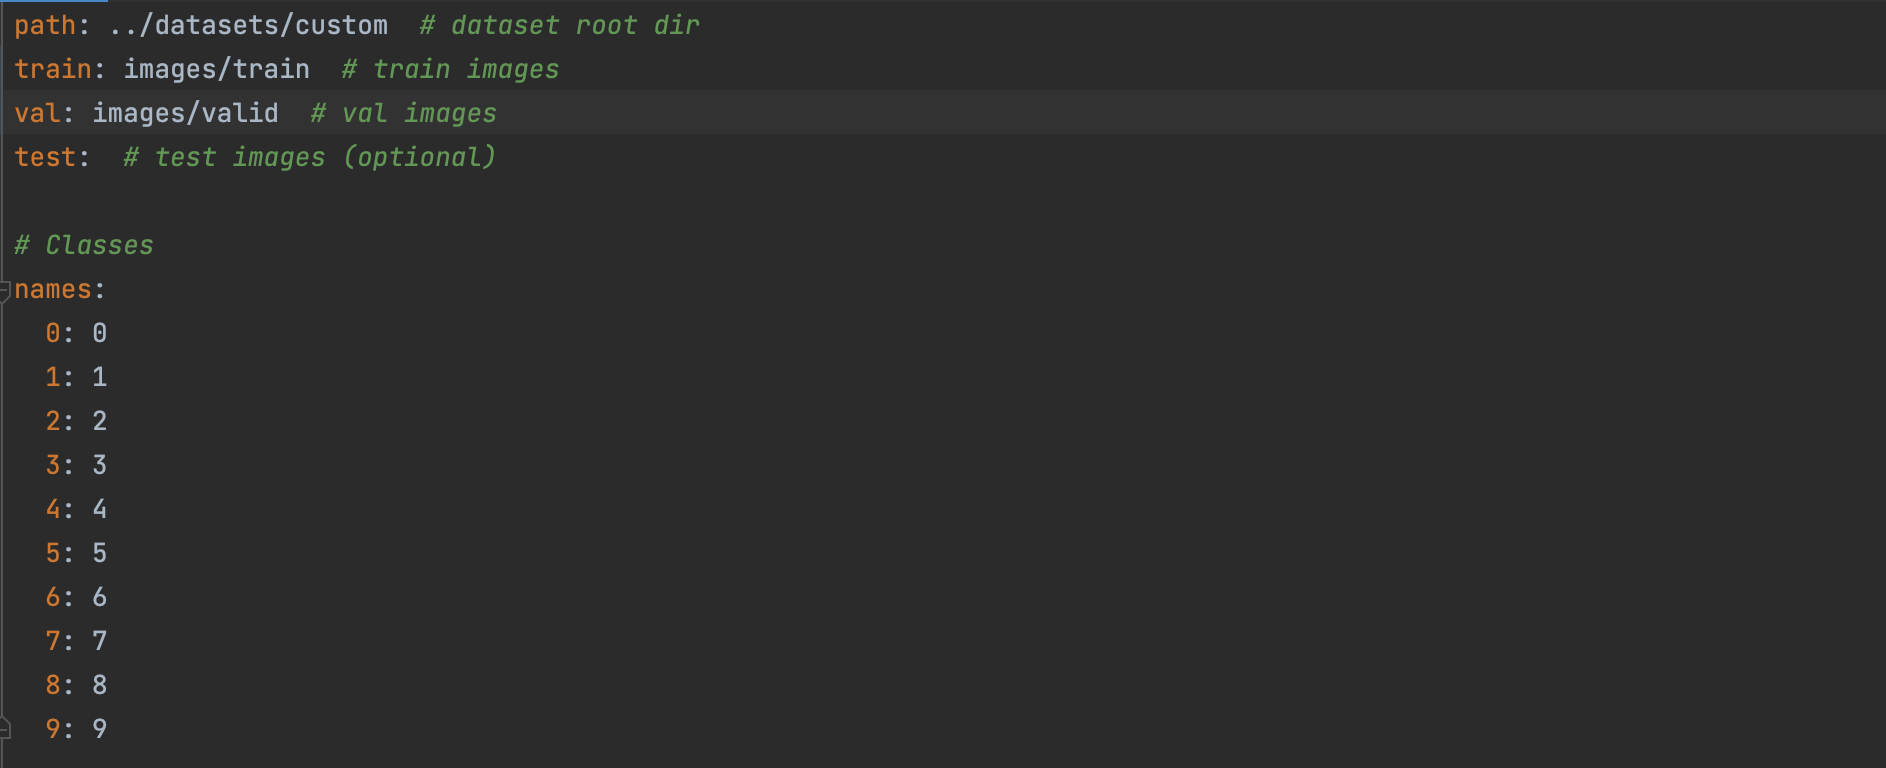

### Step 4: Modify dataloaders.py, plots.py and vals.py

The original model DOES NOT accept .npy. Therefore, we need to modify dataloaders.py, plots.py and vals.py. Copy the following code to the appropriate files.

In [ ]:
# Copy this file to dataloaders.py


# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Dataloaders and dataset utils
"""

import contextlib
import glob
import hashlib
import json
import math
import os
import random
import shutil
import time
from itertools import repeat
from multiprocessing.pool import Pool, ThreadPool
from pathlib import Path
from threading import Thread
from urllib.parse import urlparse

import numpy as np
import psutil
import torch
import torch.nn.functional as F
import torchvision
import yaml
from PIL import ExifTags, Image, ImageOps
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
from tqdm import tqdm

from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste,
                                 letterbox, mixup, random_perspective)
from utils.general import (DATASETS_DIR, LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, check_dataset, check_requirements,
                           check_yaml, clean_str, cv2, is_colab, is_kaggle, segments2boxes, unzip_file, xyn2xy,
                           xywh2xyxy, xywhn2xyxy, xyxy2xywhn)
from utils.torch_utils import torch_distributed_zero_first

# Parameters
HELP_URL = 'See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data'
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm', 'npy'  # include image suffixes
VID_FORMATS = 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv'  # include video suffixes
LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
PIN_MEMORY = str(os.getenv('PIN_MEMORY', True)).lower() == 'true'  # global pin_memory for dataloaders

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def get_hash(paths):
    # Returns a single hash value of a list of paths (files or dirs)
    size = sum(os.path.getsize(p) for p in paths if os.path.exists(p))  # sizes
    h = hashlib.sha256(str(size).encode())  # hash sizes
    h.update(''.join(paths).encode())  # hash paths
    return h.hexdigest()  # return hash


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    with contextlib.suppress(Exception):
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270 or 90
            s = (s[1], s[0])
    return s


def exif_transpose(image):
    """
    Transpose a PIL image accordingly if it has an EXIF Orientation tag.
    Inplace version of https://github.com/python-pillow/Pillow/blob/master/src/PIL/ImageOps.py exif_transpose()

    :param image: The image to transpose.
    :return: An image.
    """
    exif = image.getexif()
    orientation = exif.get(0x0112, 1)  # default 1
    if orientation > 1:
        method = {
            2: Image.FLIP_LEFT_RIGHT,
            3: Image.ROTATE_180,
            4: Image.FLIP_TOP_BOTTOM,
            5: Image.TRANSPOSE,
            6: Image.ROTATE_270,
            7: Image.TRANSVERSE,
            8: Image.ROTATE_90}.get(orientation)
        if method is not None:
            image = image.transpose(method)
            del exif[0x0112]
            image.info['exif'] = exif.tobytes()
    return image


def seed_worker(worker_id):
    # Set dataloader worker seed https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def create_dataloader(path,
                      imgsz,
                      batch_size,
                      stride,
                      single_cls=False,
                      hyp=None,
                      augment=False,
                      cache=False,
                      pad=0.0,
                      rect=False,
                      rank=-1,
                      workers=8,
                      image_weights=False,
                      quad=False,
                      prefix='',
                      shuffle=False,
                      seed=0):
    if rect and shuffle:
        LOGGER.warning('WARNING ⚠️ --rect is incompatible with DataLoader shuffle, setting shuffle=False')
        shuffle = False
    with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
        dataset = LoadImagesAndLabels(
            path,
            imgsz,
            batch_size,
            augment=augment,  # augmentation
            hyp=hyp,  # hyperparameters
            rect=rect,  # rectangular batches
            cache_images=cache,
            single_cls=single_cls,
            stride=int(stride),
            pad=pad,
            image_weights=image_weights,
            prefix=prefix)

    batch_size = min(batch_size, len(dataset))
    nd = torch.cuda.device_count()  # number of CUDA devices
    nw = min([os.cpu_count() // max(nd, 1), batch_size if batch_size > 1 else 0, workers])  # number of workers
    sampler = None if rank == -1 else distributed.DistributedSampler(dataset, shuffle=shuffle)
    loader = DataLoader if image_weights else InfiniteDataLoader  # only DataLoader allows for attribute updates
    generator = torch.Generator()
    generator.manual_seed(6148914691236517205 + seed + RANK)
    return loader(dataset,
                  batch_size=batch_size,
                  shuffle=shuffle and sampler is None,
                  num_workers=nw,
                  sampler=sampler,
                  pin_memory=PIN_MEMORY,
                  collate_fn=LoadImagesAndLabels.collate_fn4 if quad else LoadImagesAndLabels.collate_fn,
                  worker_init_fn=seed_worker,
                  generator=generator), dataset


class InfiniteDataLoader(dataloader.DataLoader):
    """ Dataloader that reuses workers

    Uses same syntax as vanilla DataLoader
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for _ in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler:
    """ Sampler that repeats forever

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


class LoadScreenshots:
    # YOLOv5 screenshot dataloader, i.e. `python detect.py --source "screen 0 100 100 512 256"`
    def __init__(self, source, img_size=640, stride=32, auto=True, transforms=None):
        # source = [screen_number left top width height] (pixels)
        check_requirements('mss')
        import mss

        source, *params = source.split()
        self.screen, left, top, width, height = 0, None, None, None, None  # default to full screen 0
        if len(params) == 1:
            self.screen = int(params[0])
        elif len(params) == 4:
            left, top, width, height = (int(x) for x in params)
        elif len(params) == 5:
            self.screen, left, top, width, height = (int(x) for x in params)
        self.img_size = img_size
        self.stride = stride
        self.transforms = transforms
        self.auto = auto
        self.mode = 'stream'
        self.frame = 0
        self.sct = mss.mss()

        # Parse monitor shape
        monitor = self.sct.monitors[self.screen]
        self.top = monitor['top'] if top is None else (monitor['top'] + top)
        self.left = monitor['left'] if left is None else (monitor['left'] + left)
        self.width = width or monitor['width']
        self.height = height or monitor['height']
        self.monitor = {'left': self.left, 'top': self.top, 'width': self.width, 'height': self.height}

    def __iter__(self):
        return self

    def __next__(self):
        # mss screen capture: get raw pixels from the screen as np array
        im0 = np.array(self.sct.grab(self.monitor))[:, :, :3]  # [:, :, :3] BGRA to BGR
        s = f'screen {self.screen} (LTWH): {self.left},{self.top},{self.width},{self.height}: '

        if self.transforms:
            im = self.transforms(im0)  # transforms
        else:
            im = letterbox(im0, self.img_size, stride=self.stride, auto=self.auto)[0]  # padded resize
            im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            im = np.ascontiguousarray(im)  # contiguous
        self.frame += 1
        return str(self.screen), im, im0, None, s  # screen, img, original img, im0s, s


class LoadImages:
    # YOLOv5 image/video dataloader, i.e. `python detect.py --source image.jpg/vid.mp4`
    def __init__(self, path, img_size=640, stride=32, auto=True, transforms=None, vid_stride=1):
        if isinstance(path, str) and Path(path).suffix == '.txt':  # *.txt file with img/vid/dir on each line
            path = Path(path).read_text().rsplit()
        files = []
        for p in sorted(path) if isinstance(path, (list, tuple)) else [path]:
            p = str(Path(p).resolve())
            if '*' in p:
                files.extend(sorted(glob.glob(p, recursive=True)))  # glob
            elif os.path.isdir(p):
                files.extend(sorted(glob.glob(os.path.join(p, '*.*'))))  # dir
            elif os.path.isfile(p):
                files.append(p)  # files
            else:
                raise FileNotFoundError(f'{p} does not exist')

        images = [x for x in files if x.split('.')[-1].lower() in IMG_FORMATS]
        videos = [x for x in files if x.split('.')[-1].lower() in VID_FORMATS]
        ni, nv = len(images), len(videos)

        self.img_size = img_size
        self.stride = stride
        self.files = images + videos
        self.nf = ni + nv  # number of files
        self.video_flag = [False] * ni + [True] * nv
        self.mode = 'image'
        self.auto = auto
        self.transforms = transforms  # optional
        self.vid_stride = vid_stride  # video frame-rate stride
        if any(videos):
            self._new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nf > 0, f'No images or videos found in {p}. ' \
                            f'Supported formats are:\nimages: {IMG_FORMATS}\nvideos: {VID_FORMATS}'

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            for _ in range(self.vid_stride):
                self.cap.grab()
            ret_val, im0 = self.cap.retrieve()
            while not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nf:  # last video
                    raise StopIteration
                path = self.files[self.count]
                self._new_video(path)
                ret_val, im0 = self.cap.read()

            self.frame += 1
            # im0 = self._cv2_rotate(im0)  # for use if cv2 autorotation is False
            s = f'video {self.count + 1}/{self.nf} ({self.frame}/{self.frames}) {path}: '

        else:
            # Read image
            self.count += 1
            im0 = cv2.imread(path)  # BGR
            assert im0 is not None, f'Image Not Found {path}'
            s = f'image {self.count}/{self.nf} {path}: '

        if self.transforms:
            im = self.transforms(im0)  # transforms
        else:
            im = letterbox(im0, self.img_size, stride=self.stride, auto=self.auto)[0]  # padded resize
            im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            im = np.ascontiguousarray(im)  # contiguous

        return path, im, im0, self.cap, s

    def _new_video(self, path):
        # Create a new video capture object
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride)
        self.orientation = int(self.cap.get(cv2.CAP_PROP_ORIENTATION_META))  # rotation degrees
        # self.cap.set(cv2.CAP_PROP_ORIENTATION_AUTO, 0)  # disable https://github.com/ultralytics/yolov5/issues/8493

    def _cv2_rotate(self, im):
        # Rotate a cv2 video manually
        if self.orientation == 0:
            return cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
        elif self.orientation == 180:
            return cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif self.orientation == 90:
            return cv2.rotate(im, cv2.ROTATE_180)
        return im

    def __len__(self):
        return self.nf  # number of files


class LoadStreams:
    # YOLOv5 streamloader, i.e. `python detect.py --source 'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP streams`
    def __init__(self, sources='file.streams', img_size=640, stride=32, auto=True, transforms=None, vid_stride=1):
        torch.backends.cudnn.benchmark = True  # faster for fixed-size inference
        self.mode = 'stream'
        self.img_size = img_size
        self.stride = stride
        self.vid_stride = vid_stride  # video frame-rate stride
        sources = Path(sources).read_text().rsplit() if os.path.isfile(sources) else [sources]
        n = len(sources)
        self.sources = [clean_str(x) for x in sources]  # clean source names for later
        self.imgs, self.fps, self.frames, self.threads = [None] * n, [0] * n, [0] * n, [None] * n
        for i, s in enumerate(sources):  # index, source
            # Start thread to read frames from video stream
            st = f'{i + 1}/{n}: {s}... '
            if urlparse(s).hostname in ('www.youtube.com', 'youtube.com', 'youtu.be'):  # if source is YouTube video
                # YouTube format i.e. 'https://www.youtube.com/watch?v=Zgi9g1ksQHc' or 'https://youtu.be/LNwODJXcvt4'
                check_requirements(('pafy', 'youtube_dl==2020.12.2'))
                import pafy
                s = pafy.new(s).getbest(preftype='mp4').url  # YouTube URL
            s = eval(s) if s.isnumeric() else s  # i.e. s = '0' local webcam
            if s == 0:
                assert not is_colab(), '--source 0 webcam unsupported on Colab. Rerun command in a local environment.'
                assert not is_kaggle(), '--source 0 webcam unsupported on Kaggle. Rerun command in a local environment.'
            cap = cv2.VideoCapture(s)
            assert cap.isOpened(), f'{st}Failed to open {s}'
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)  # warning: may return 0 or nan
            self.frames[i] = max(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 0) or float('inf')  # infinite stream fallback
            self.fps[i] = max((fps if math.isfinite(fps) else 0) % 100, 0) or 30  # 30 FPS fallback

            _, self.imgs[i] = cap.read()  # guarantee first frame
            self.threads[i] = Thread(target=self.update, args=([i, cap, s]), daemon=True)
            LOGGER.info(f'{st} Success ({self.frames[i]} frames {w}x{h} at {self.fps[i]:.2f} FPS)')
            self.threads[i].start()
        LOGGER.info('')  # newline

        # check for common shapes
        s = np.stack([letterbox(x, img_size, stride=stride, auto=auto)[0].shape for x in self.imgs])
        self.rect = np.unique(s, axis=0).shape[0] == 1  # rect inference if all shapes equal
        self.auto = auto and self.rect
        self.transforms = transforms  # optional
        if not self.rect:
            LOGGER.warning('WARNING ⚠️ Stream shapes differ. For optimal performance supply similarly-shaped streams.')

    def update(self, i, cap, stream):
        # Read stream `i` frames in daemon thread
        n, f = 0, self.frames[i]  # frame number, frame array
        while cap.isOpened() and n < f:
            n += 1
            cap.grab()  # .read() = .grab() followed by .retrieve()
            if n % self.vid_stride == 0:
                success, im = cap.retrieve()
                if success:
                    self.imgs[i] = im
                else:
                    LOGGER.warning('WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.')
                    self.imgs[i] = np.zeros_like(self.imgs[i])
                    cap.open(stream)  # re-open stream if signal was lost
            time.sleep(0.0)  # wait time

    def __iter__(self):
        self.count = -1
        return self

    def __next__(self):
        self.count += 1
        if not all(x.is_alive() for x in self.threads) or cv2.waitKey(1) == ord('q'):  # q to quit
            cv2.destroyAllWindows()
            raise StopIteration

        im0 = self.imgs.copy()
        if self.transforms:
            im = np.stack([self.transforms(x) for x in im0])  # transforms
        else:
            im = np.stack([letterbox(x, self.img_size, stride=self.stride, auto=self.auto)[0] for x in im0])  # resize
            im = im[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW
            im = np.ascontiguousarray(im)  # contiguous

        return self.sources, im, im0, None, ''

    def __len__(self):
        return len(self.sources)  # 1E12 frames = 32 streams at 30 FPS for 30 years


def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    if len(img_paths) > 1:
        return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]
    else:
        return [(sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0])[:-1] + 'Y.npy' for x in img_paths]



class LoadImagesAndLabels(Dataset):
    # YOLOv5 train_loader/val_loader, loads images and labels for training and validation
    cache_version = 0.6  # dataset labels *.cache version
    rand_interp_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4]

    def __init__(self,
                 path,
                 img_size=640,
                 batch_size=16,
                 augment=False,
                 hyp=None,
                 rect=False,
                 image_weights=False,
                 cache_images=False,
                 single_cls=False,
                 stride=32,
                 pad=0.0,
                 min_items=0,
                 prefix=''):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.image_weights = image_weights
        self.rect = False if image_weights else rect
        self.mosaic = self.augment and not self.rect  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride
        self.path = path
        self.albumentations = Albumentations(size=img_size) if augment else None
        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                    # f = list(p.rglob('*.*'))  # pathlib
                elif p.is_file():  # file
                    with open(p) as t:
                        t = t.read().strip().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent, 1) if x.startswith('./') else x for x in t]  # to global path
                        # f += [p.parent / x.lstrip(os.sep) for x in t]  # to global path (pathlib)
                else:
                    raise FileNotFoundError(f'{prefix}{p} does not exist')
            # f is a list contain image filename
            if f[0].split('.')[-1].lower() == 'jpeg' or  f[0].split('.')[-1].lower() == 'jpg':
                self.im_files = sorted(x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in IMG_FORMATS)
            # self.img_files = sorted([x for x in f if x.suffix[1:].lower() in IMG_FORMATS])  # pathlib
            else:
                self.im_files = list(np.load('../datasets/custom/images/train/train_X.npy'))
            assert self.im_files, f'{prefix}No images found'
        except Exception as e:
            raise Exception(f'{prefix}Error loading data from {path}: {e}\n{HELP_URL}') from e
        # Check cache
        if type(self.im_files[0]) == str:
            self.label_files = img2label_paths(self.im_files)  # labels
        else:
            self.label_files = list(np.load('../datasets/custom/labels/train/train_Y.npy'))

        if type(self.label_files[0]) == str:
            cache_path = (p if p.is_file() else Path(self.label_files[0]).parent).with_suffix('.cache')
        else:
            cache_path = Path('../datasets/custom/labels/train.cache')
        try:
            cache, exists = np.load(cache_path, allow_pickle=True).item(), True  # load dict
            assert cache['version'] == self.cache_version  # matches current version
            # assert cache['hash'] == get_hash(self.label_files + self.im_files)  # identical hash
        except Exception:
            cache, exists = self.cache_labels(cache_path, prefix), False  # run cache ops

        # Display cache
        nf, nm, ne, nc, n = cache.pop('results')  # found, missing, empty, corrupt, total
        if exists and LOCAL_RANK in {-1, 0}:
            d = f'Scanning {cache_path}... {nf} images, {nm + ne} backgrounds, {nc} corrupt'
            tqdm(None, desc=prefix + d, total=n, initial=n, bar_format=TQDM_BAR_FORMAT)  # display cache results
            if cache['msgs']:
                LOGGER.info('\n'.join(cache['msgs']))  # display warnings
        # assert nf > 0 or not augment, f'{prefix}No labels found in {cache_path}, can not start training. {HELP_URL}'

        # Read cache
        [cache.pop(k) for k in ('version', 'msgs')]  # remove items
        # print(*cache.values())
        labels, shapes, self.segments = zip(*cache.values())
        nl = len(np.concatenate(labels, 0))  # number of labels
        assert nl > 0 or not augment, f'{prefix}All labels empty in {cache_path}, can not start training. {HELP_URL}'

        self.labels = list(labels)
        # self.labels = np.load('../datasets/custom/labels/train/train_Y.npy')
        self.shapes = np.array(shapes)
        if type(list(cache.keys())[0]) == int:
            self.im_files = self.im_files
            self.label_files = self.label_files
        else:
            self.im_files = list(cache.keys())  # update
            self.label_files = img2label_paths(cache.keys())  # update

        # Filter images
        if min_items:
            include = np.array([len(x) >= min_items for x in self.labels]).nonzero()[0].astype(int)
            LOGGER.info(f'{prefix}{n - len(include)}/{n} images filtered from dataset')
            self.im_files = [self.im_files[i] for i in include]
            self.label_files = [self.label_files[i] for i in include]
            self.labels = [self.labels[i] for i in include]
            self.segments = [self.segments[i] for i in include]
            self.shapes = self.shapes[include]  # wh

        # Create indices
        n = len(self.shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)

        # Update labels
        include_class = []  # filter labels to include only these classes (optional)
        self.segments = list(self.segments)
        include_class_array = np.array(include_class).reshape(1, -1)
        for i, (label, segment) in enumerate(zip(self.labels, self.segments)):
            if include_class:
                j = (label[:, 0:1] == include_class_array).any(1)
                self.labels[i] = label[j]
                if segment:
                    self.segments[i] = [segment[idx] for idx, elem in enumerate(j) if elem]
            if single_cls:  # single-class training, merge all classes into 0
                self.labels[i][:, 0] = 0

        # Rectangular Training
        if self.rect:
            # Sort by aspect ratio
            s = self.shapes  # wh
            ar = s[:, 1] / s[:, 0]  # aspect ratio
            irect = ar.argsort()
            self.im_files = [self.im_files[i] for i in irect]
            self.label_files = [self.label_files[i] for i in irect]
            self.labels = [self.labels[i] for i in irect]
            self.segments = [self.segments[i] for i in irect]
            self.shapes = s[irect]  # wh
            ar = ar[irect]

            # Set training image shapes
            shapes = [[1, 1]] * nb
            for i in range(nb):
                ari = ar[bi == i]
                mini, maxi = ari.min(), ari.max()
                if maxi < 1:
                    shapes[i] = [maxi, 1]
                elif mini > 1:
                    shapes[i] = [1, 1 / mini]

            self.batch_shapes = np.ceil(np.array(shapes) * img_size / stride + pad).astype(int) * stride

        # Cache images into RAM/disk for faster training
        if cache_images == 'ram' and not self.check_cache_ram(prefix=prefix):
            cache_images = False
        self.ims = [None] * n
        if type(self.im_files[0]) == str:
            self.npy_files = [Path(f).with_suffix('.npy') for f in self.im_files]
        else:
            self.npy_files = self.im_files

        if cache_images:
            b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
            self.im_hw0, self.im_hw = [None] * n, [None] * n
            fcn = self.cache_images_to_disk if cache_images == 'disk' else self.load_image
            results = ThreadPool(NUM_THREADS).imap(fcn, range(n))
            pbar = tqdm(enumerate(results), total=n, bar_format=TQDM_BAR_FORMAT, disable=LOCAL_RANK > 0)
            for i, x in pbar:
                if cache_images == 'disk':
                    b += self.npy_files[i].stat().st_size
                else:  # 'ram'
                    self.ims[i], self.im_hw0[i], self.im_hw[i] = x  # im, hw_orig, hw_resized = load_image(self, i)
                    b += self.ims[i].nbytes
                pbar.desc = f'{prefix}Caching images ({b / gb:.1f}GB {cache_images})'
            pbar.close()

    def check_cache_ram(self, safety_margin=0.1, prefix=''):
        # Check image caching requirements vs available memory
        b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
        n = min(self.n, 30)  # extrapolate from 30 random images
        for _ in range(n):
            im = cv2.imread(random.choice(self.im_files))  # sample image
            ratio = self.img_size / max(im.shape[0], im.shape[1])  # max(h, w)  # ratio
            b += im.nbytes * ratio ** 2
        mem_required = b * self.n / n  # GB required to cache dataset into RAM
        mem = psutil.virtual_memory()
        cache = mem_required * (1 + safety_margin) < mem.available  # to cache or not to cache, that is the question
        if not cache:
            LOGGER.info(f'{prefix}{mem_required / gb:.1f}GB RAM required, '
                        f'{mem.available / gb:.1f}/{mem.total / gb:.1f}GB available, '
                        f"{'caching images ✅' if cache else 'not caching images ⚠️'}")
        return cache

    def cache_labels(self, path=Path('./labels.cache'), prefix=''):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        nm, nf, ne, nc, msgs = 0, 0, 0, 0, []  # number missing, found, empty, corrupt, messages
        desc = f'{prefix}Scanning {path.parent / path.stem}...'
        # print(self.label_files)
        with Pool(NUM_THREADS) as pool:
            pbar = tqdm(pool.imap(verify_image_label, zip(self.im_files, self.label_files, repeat(prefix))),
                        desc=desc,
                        total=len(self.im_files),
                        bar_format=TQDM_BAR_FORMAT)

            i = 0
            for im_file, lb, shape, segments, nm_f, nf_f, ne_f, nc_f, msg in pbar:
                nm += nm_f
                nf += nf_f
                ne += ne_f
                nc += nc_f
                if type(im_file) == str:
                    x[im_file] = [lb, shape, segments]
                elif type(im_file) != str:
                    x[i] = [lb, shape, segments]
                if msg:
                    msgs.append(msg)
                pbar.desc = f'{desc} {nf} images, {nm + ne} backgrounds, {nc} corrupt'
                i += 1

        pbar.close()
        if msgs:
            LOGGER.info('\n'.join(msgs))
        if nf == 0:
            LOGGER.warning(f'{prefix}WARNING ⚠️ No labels found in {path}. {HELP_URL}')
        # x['hash'] = get_hash(self.label_files + self.im_files)
        x['results'] = nf, nm, ne, nc, len(self.im_files)
        x['msgs'] = msgs  # warnings
        x['version'] = self.cache_version  # cache version
        try:
            np.save(path, x)  # save cache for next time
            path.with_suffix('.cache.npy').rename(path)  # remove .npy suffix
            LOGGER.info(f'{prefix}New cache created: {path}')
        except Exception as e:
            LOGGER.warning(f'{prefix}WARNING ⚠️ Cache directory {path.parent} is not writeable: {e}')  # not writeable
        return x

    def __len__(self):
        return len(self.im_files)

    # def __iter__(self):
    #     self.count = -1
    #     print('ran dataset iter')
    #     #self.shuffled_vector = np.random.permutation(self.nF) if self.augment else np.arange(self.nF)
    #     return self

    def __getitem__(self, index):
        index = self.indices[index]  # linear, shuffled, or image_weights
        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        if mosaic:
            # Load mosaic
            img, labels = self.load_mosaic(index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels = mixup(img, labels, *self.load_mosaic(random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = self.load_image(index)

            # Letterbox
            shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            labels = self.labels[index].copy()
            if labels.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])

            if self.augment:
                img, labels = random_perspective(img,
                                                 labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

        nl = len(labels)  # number of labels
        if nl:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0], clip=True, eps=1E-3)

        if self.augment:
            # Albumentations
            img, labels = self.albumentations(img, labels)
            nl = len(labels)  # update after albumentations

            # HSV color-space
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]

            # Flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]

            # Cutouts
            # labels = cutout(img, labels, p=0.5)
            # nl = len(labels)  # update after cutout

        labels_out = torch.zeros((nl, 6))
        if nl:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), labels_out, self.im_files[index], shapes

    def load_image(self, i):
        # Loads 1 image from dataset index 'i', returns (im, original hw, resized hw)
        im, f, fn = self.ims[i], self.im_files[i], self.npy_files[i],
        if im is None:  # not cached in RAM
            if type(fn) == np.ndarray:
                im = fn.reshape(64, 64, 3)
            elif fn.exists():  # load npy
                im = np.load(fn)
            else:  # read image
                im = cv2.imread(f)  # BGR
                assert im is not None, f'Image Not Found {f}'
            # print(im.shape)
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
                im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)

            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        return self.ims[i], self.im_hw0[i], self.im_hw[i]  # im, hw_original, hw_resized

    def cache_images_to_disk(self, i):
        # Saves an image as an *.npy file for faster loading
        f = self.npy_files[i]
        if not f.exists():
            np.save(f.as_posix(), cv2.imread(self.im_files[i]))

    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4, segments4 = [], []
        s = self.img_size
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(self.indices, k=3)  # 3 additional image indices
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padw, padh) for x in segments]
            labels4.append(labels)
            segments4.extend(segments)


        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, 1:], *segments4):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate

        # Augment
        img4, labels4, segments4 = copy_paste(img4, labels4, segments4, p=self.hyp['copy_paste'])
        img4, labels4 = random_perspective(img4,
                                           labels4,
                                           segments4,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img4, labels4

    def load_mosaic9(self, index):
        # YOLOv5 9-mosaic loader. Loads 1 image + 8 random images into a 9-image mosaic
        labels9, segments9 = [], []
        s = self.img_size
        indices = [index] + random.choices(self.indices, k=8)  # 8 additional image indices
        random.shuffle(indices)
        hp, wp = -1, -1  # height, width previous
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img9
            if i == 0:  # center
                img9 = np.full((s * 3, s * 3, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                h0, w0 = h, w
                c = s, s, s + w, s + h  # xmin, ymin, xmax, ymax (base) coordinates
            elif i == 1:  # top
                c = s, s - h, s + w, s
            elif i == 2:  # top right
                c = s + wp, s - h, s + wp + w, s
            elif i == 3:  # right
                c = s + w0, s, s + w0 + w, s + h
            elif i == 4:  # bottom right
                c = s + w0, s + hp, s + w0 + w, s + hp + h
            elif i == 5:  # bottom
                c = s + w0 - w, s + h0, s + w0, s + h0 + h
            elif i == 6:  # bottom left
                c = s + w0 - wp - w, s + h0, s + w0 - wp, s + h0 + h
            elif i == 7:  # left
                c = s - w, s + h0 - h, s, s + h0
            elif i == 8:  # top left
                c = s - w, s + h0 - hp - h, s, s + h0 - hp

            padx, pady = c[:2]
            x1, y1, x2, y2 = (max(x, 0) for x in c)  # allocate coords

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padx, pady)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padx, pady) for x in segments]
            labels9.append(labels)
            segments9.extend(segments)

            # Image
            img9[y1:y2, x1:x2] = img[y1 - pady:, x1 - padx:]  # img9[ymin:ymax, xmin:xmax]
            hp, wp = h, w  # height, width previous

        # Offset
        yc, xc = (int(random.uniform(0, s)) for _ in self.mosaic_border)  # mosaic center x, y
        img9 = img9[yc:yc + 2 * s, xc:xc + 2 * s]

        # Concat/clip labels
        labels9 = np.concatenate(labels9, 0)
        labels9[:, [1, 3]] -= xc
        labels9[:, [2, 4]] -= yc
        c = np.array([xc, yc])  # centers
        segments9 = [x - c for x in segments9]

        for x in (labels9[:, 1:], *segments9):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img9, labels9 = replicate(img9, labels9)  # replicate

        # Augment
        img9, labels9, segments9 = copy_paste(img9, labels9, segments9, p=self.hyp['copy_paste'])
        img9, labels9 = random_perspective(img9,
                                           labels9,
                                           segments9,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img9, labels9

    @staticmethod
    def collate_fn(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        for i, lb in enumerate(label):
            lb[:, 0] = i  # add target image index for build_targets()
        return torch.stack(im, 0), torch.cat(label, 0), path, shapes

    @staticmethod
    def collate_fn4(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        n = len(shapes) // 4
        im4, label4, path4, shapes4 = [], [], path[:n], shapes[:n]

        ho = torch.tensor([[0.0, 0, 0, 1, 0, 0]])
        wo = torch.tensor([[0.0, 0, 1, 0, 0, 0]])
        s = torch.tensor([[1, 1, 0.5, 0.5, 0.5, 0.5]])  # scale
        for i in range(n):  # zidane torch.zeros(16,3,720,1280)  # BCHW
            i *= 4
            if random.random() < 0.5:
                im1 = F.interpolate(im[i].unsqueeze(0).float(), scale_factor=2.0, mode='bilinear',
                                    align_corners=False)[0].type(im[i].type())
                lb = label[i]
            else:
                im1 = torch.cat((torch.cat((im[i], im[i + 1]), 1), torch.cat((im[i + 2], im[i + 3]), 1)), 2)
                lb = torch.cat((label[i], label[i + 1] + ho, label[i + 2] + wo, label[i + 3] + ho + wo), 0) * s
            im4.append(im1)
            label4.append(lb)

        for i, lb in enumerate(label4):
            lb[:, 0] = i  # add target image index for build_targets()

        return torch.stack(im4, 0), torch.cat(label4, 0), path4, shapes4


# Ancillary functions --------------------------------------------------------------------------------------------------
def flatten_recursive(path=DATASETS_DIR / 'coco128'):
    # Flatten a recursive directory by bringing all files to top level
    new_path = Path(f'{str(path)}_flat')
    if os.path.exists(new_path):
        shutil.rmtree(new_path)  # delete output folder
    os.makedirs(new_path)  # make new output folder
    for file in tqdm(glob.glob(f'{str(Path(path))}/**/*.*', recursive=True)):
        shutil.copyfile(file, new_path / Path(file).name)


def extract_boxes(path=DATASETS_DIR / 'coco128'):  # from utils.dataloaders import *; extract_boxes()
    # Convert detection dataset into classification dataset, with one directory per class
    path = Path(path)  # images dir
    shutil.rmtree(path / 'classification') if (path / 'classification').is_dir() else None  # remove existing
    files = list(path.rglob('*.*'))
    n = len(files)  # number of files
    for im_file in tqdm(files, total=n):
        if im_file.suffix[1:] in IMG_FORMATS:
            # image
            im = cv2.imread(str(im_file))[..., ::-1]  # BGR to RGB
            h, w = im.shape[:2]

            # labels
            lb_file = Path(img2label_paths([str(im_file)])[0])
            if Path(lb_file).exists():
                with open(lb_file) as f:
                    lb = np.array([x.split() for x in f.read().strip().splitlines()], dtype=np.float32)  # labels

                for j, x in enumerate(lb):
                    c = int(x[0])  # class
                    f = (path / 'classifier') / f'{c}' / f'{path.stem}_{im_file.stem}_{j}.jpg'  # new filename
                    if not f.parent.is_dir():
                        f.parent.mkdir(parents=True)

                    b = x[1:] * [w, h, w, h]  # box
                    # b[2:] = b[2:].max()  # rectangle to square
                    b[2:] = b[2:] * 1.2 + 3  # pad
                    b = xywh2xyxy(b.reshape(-1, 4)).ravel().astype(int)

                    b[[0, 2]] = np.clip(b[[0, 2]], 0, w)  # clip boxes outside of image
                    b[[1, 3]] = np.clip(b[[1, 3]], 0, h)
                    assert cv2.imwrite(str(f), im[b[1]:b[3], b[0]:b[2]]), f'box failure in {f}'


def autosplit(path=DATASETS_DIR / 'coco128/images', weights=(0.9, 0.1, 0.0), annotated_only=False):
    """ Autosplit a dataset into train/val/test splits and save path/autosplit_*.txt files
    Usage: from utils.dataloaders import *; autosplit()
    Arguments
        path:            Path to images directory
        weights:         Train, val, test weights (list, tuple)
        annotated_only:  Only use images with an annotated txt file
    """
    path = Path(path)  # images dir
    files = sorted(x for x in path.rglob('*.*') if x.suffix[1:].lower() in IMG_FORMATS)  # image files only
    n = len(files)  # number of files
    random.seed(0)  # for reproducibility
    indices = random.choices([0, 1, 2], weights=weights, k=n)  # assign each image to a split

    txt = ['autosplit_train.txt', 'autosplit_val.txt', 'autosplit_test.txt']  # 3 txt files
    for x in txt:
        if (path.parent / x).exists():
            (path.parent / x).unlink()  # remove existing

    print(f'Autosplitting images from {path}' + ', using *.txt labeled images only' * annotated_only)
    for i, img in tqdm(zip(indices, files), total=n):
        if not annotated_only or Path(img2label_paths([str(img)])[0]).exists():  # check label
            with open(path.parent / txt[i], 'a') as f:
                f.write(f'./{img.relative_to(path.parent).as_posix()}' + '\n')  # add image to txt file


def verify_image_label(args):
    # Verify one image-label pair
    im_file, lb_file, prefix = args
    nm, nf, ne, nc, msg, segments = 0, 0, 0, 0, '', []  # number (missing, found, empty, corrupt), message, segments
    try:
        # verify images
        if 'jpg' in im_file:
            im = Image.open(im_file)
            im.verify()  # PIL verify
            shape = exif_size(im)  # image size
        else:
            im = im_file.reshape(64, 64, 3)
            shape = 64, 64
        assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
        # assert im.format.lower() in IMG_FORMATS, f'invalid image format {im.format}'
        # if im.format.lower() in ('jpg', 'jpeg'):
        #     with open(im_file, 'rb') as f:
        #         f.seek(-2, 2)
        #         if f.read() != b'\xff\xd9':  # corrupt JPEG
        #             ImageOps.exif_transpose(Image.open(im_file)).save(im_file, 'JPEG', subsampling=0, quality=100)
        #             msg = f'{prefix}WARNING ⚠️ {im_file}: corrupt JPEG restored and saved'
        # verify labels
        if type(lb_file) != str:
            nf = 1
            lb = np.array(lb_file, dtype=np.float32)
            #Ignore the segment for the moment

            nl = len(lb)
            if nl:
                # assert lb.shape[1] == 5, f'labels require 5 columns, {lb.shape[1]} columns detected'
                # assert (lb >= 0).all(), f'negative label values {lb[lb < 0]}'
                # assert (lb[:, 1:] <= 1).all(), f'non-normalized or out of bounds coordinates {lb[:, 1:][lb[:, 1:] > 1]}'
                _, i = np.unique(lb, axis=0, return_index=True)
                if len(i) < nl:  # duplicate row check
                    lb = lb[i]  # remove duplicates
                    msg = f'{prefix}WARNING ⚠️ {im_file}: {nl - len(i)} duplicate labels removed'
            else:
                ne = 1  # label empty
                lb = np.zeros((0, 5), dtype=np.float32)
            return im_file, lb, shape, segments, nm, nf, ne, nc, msg

        else:
            if os.path.isfile(lb_file):
                nf = 1  # label found
                with open(lb_file) as f:
                    lb = [x.split() for x in f.read().strip().splitlines() if len(x)]
                    if any(len(x) > 6 for x in lb):  # is segment
                        classes = np.array([x[0] for x in lb], dtype=np.float32)
                        segments = [np.array(x[1:], dtype=np.float32).reshape(-1, 2) for x in lb]  # (cls, xy1...)
                        lb = np.concatenate((classes.reshape(-1, 1), segments2boxes(segments)), 1)  # (cls, xywh)
                    lb = np.array(lb, dtype=np.float32)
                nl = len(lb)
                if nl:
                    assert lb.shape[1] == 5, f'labels require 5 columns, {lb.shape[1]} columns detected'
                    assert (lb >= 0).all(), f'negative label values {lb[lb < 0]}'
                    assert (lb[:, 1:] <= 1).all(), f'non-normalized or out of bounds coordinates {lb[:, 1:][lb[:, 1:] > 1]}'
                    _, i = np.unique(lb, axis=0, return_index=True)
                    if len(i) < nl:  # duplicate row check
                        lb = lb[i]  # remove duplicates
                        if segments:
                            segments = [segments[x] for x in i]
                        msg = f'{prefix}WARNING ⚠️ {im_file}: {nl - len(i)} duplicate labels removed'
                else:
                    ne = 1  # label empty
                    lb = np.zeros((0, 5), dtype=np.float32)
            else:
                nm = 1  # label missing
                lb = np.zeros((0, 5), dtype=np.float32)

            return im_file, lb, shape, segments, nm, nf, ne, nc, msg
    except Exception as e:
        nc = 1
        msg = f'{prefix}WARNING ⚠️ {im_file}: ignoring corrupt image/label: {e}'
        return [None, None, None, None, nm, nf, ne, nc, msg]


class HUBDatasetStats():
    """ Class for generating HUB dataset JSON and `-hub` dataset directory

    Arguments
        path:           Path to data.yaml or data.zip (with data.yaml inside data.zip)
        autodownload:   Attempt to download dataset if not found locally

    Usage
        from utils.dataloaders import HUBDatasetStats
        stats = HUBDatasetStats('coco128.yaml', autodownload=True)  # usage 1
        stats = HUBDatasetStats('path/to/coco128.zip')  # usage 2
        stats.get_json(save=False)
        stats.process_images()
    """

    def __init__(self, path='coco128.yaml', autodownload=False):
        # Initialize class
        zipped, data_dir, yaml_path = self._unzip(Path(path))
        try:
            with open(check_yaml(yaml_path), errors='ignore') as f:
                data = yaml.safe_load(f)  # data dict
                if zipped:
                    data['path'] = data_dir
        except Exception as e:
            raise Exception('error/HUB/dataset_stats/yaml_load') from e

        check_dataset(data, autodownload)  # download dataset if missing
        self.hub_dir = Path(data['path'] + '-hub')
        self.im_dir = self.hub_dir / 'images'
        self.im_dir.mkdir(parents=True, exist_ok=True)  # makes /images
        self.stats = {'nc': data['nc'], 'names': list(data['names'].values())}  # statistics dictionary
        self.data = data

    @staticmethod
    def _find_yaml(dir):
        # Return data.yaml file
        files = list(dir.glob('*.yaml')) or list(dir.rglob('*.yaml'))  # try root level first and then recursive
        assert files, f'No *.yaml file found in {dir}'
        if len(files) > 1:
            files = [f for f in files if f.stem == dir.stem]  # prefer *.yaml files that match dir name
            assert files, f'Multiple *.yaml files found in {dir}, only 1 *.yaml file allowed'
        assert len(files) == 1, f'Multiple *.yaml files found: {files}, only 1 *.yaml file allowed in {dir}'
        return files[0]

    def _unzip(self, path):
        # Unzip data.zip
        if not str(path).endswith('.zip'):  # path is data.yaml
            return False, None, path
        assert Path(path).is_file(), f'Error unzipping {path}, file not found'
        unzip_file(path, path=path.parent)
        dir = path.with_suffix('')  # dataset directory == zip name
        assert dir.is_dir(), f'Error unzipping {path}, {dir} not found. path/to/abc.zip MUST unzip to path/to/abc/'
        return True, str(dir), self._find_yaml(dir)  # zipped, data_dir, yaml_path

    def _hub_ops(self, f, max_dim=1920):
        # HUB ops for 1 image 'f': resize and save at reduced quality in /dataset-hub for web/app viewing
        f_new = self.im_dir / Path(f).name  # dataset-hub image filename
        try:  # use PIL
            im = Image.open(f)
            r = max_dim / max(im.height, im.width)  # ratio
            if r < 1.0:  # image too large
                im = im.resize((int(im.width * r), int(im.height * r)))
            im.save(f_new, 'JPEG', quality=50, optimize=True)  # save
        except Exception as e:  # use OpenCV
            LOGGER.info(f'WARNING ⚠️ HUB ops PIL failure {f}: {e}')
            im = cv2.imread(f)
            im_height, im_width = im.shape[:2]
            r = max_dim / max(im_height, im_width)  # ratio
            if r < 1.0:  # image too large
                im = cv2.resize(im, (int(im_width * r), int(im_height * r)), interpolation=cv2.INTER_AREA)
            cv2.imwrite(str(f_new), im)

    def get_json(self, save=False, verbose=False):
        # Return dataset JSON for Ultralytics HUB
        def _round(labels):
            # Update labels to integer class and 6 decimal place floats
            return [[int(c), *(round(x, 4) for x in points)] for c, *points in labels]

        for split in 'train', 'val', 'test':
            if self.data.get(split) is None:
                self.stats[split] = None  # i.e. no test set
                continue
            dataset = LoadImagesAndLabels(self.data[split])  # load dataset
            x = np.array([
                np.bincount(label[:, 0].astype(int), minlength=self.data['nc'])
                for label in tqdm(dataset.labels, total=dataset.n, desc='Statistics')])  # shape(128x80)
            self.stats[split] = {
                'instance_stats': {
                    'total': int(x.sum()),
                    'per_class': x.sum(0).tolist()},
                'image_stats': {
                    'total': dataset.n,
                    'unlabelled': int(np.all(x == 0, 1).sum()),
                    'per_class': (x > 0).sum(0).tolist()},
                'labels': [{
                    str(Path(k).name): _round(v.tolist())} for k, v in zip(dataset.im_files, dataset.labels)]}

        # Save, print and return
        if save:
            stats_path = self.hub_dir / 'stats.json'
            print(f'Saving {stats_path.resolve()}...')
            with open(stats_path, 'w') as f:
                json.dump(self.stats, f)  # save stats.json
        if verbose:
            print(json.dumps(self.stats, indent=2, sort_keys=False))
        return self.stats

    def process_images(self):
        # Compress images for Ultralytics HUB
        for split in 'train', 'val', 'test':
            if self.data.get(split) is None:
                continue
            dataset = LoadImagesAndLabels(self.data[split])  # load dataset
            desc = f'{split} images'
            for _ in tqdm(ThreadPool(NUM_THREADS).imap(self._hub_ops, dataset.im_files), total=dataset.n, desc=desc):
                pass
        print(f'Done. All images saved to {self.im_dir}')
        return self.im_dir


# Classification dataloaders -------------------------------------------------------------------------------------------
class ClassificationDataset(torchvision.datasets.ImageFolder):
    """
    YOLOv5 Classification Dataset.
    Arguments
        root:  Dataset path
        transform:  torchvision transforms, used by default
        album_transform: Albumentations transforms, used if installed
    """

    def __init__(self, root, augment, imgsz, cache=False):
        super().__init__(root=root)
        self.torch_transforms = classify_transforms(imgsz)
        self.album_transforms = classify_albumentations(augment, imgsz) if augment else None
        self.cache_ram = cache is True or cache == 'ram'
        self.cache_disk = cache == 'disk'
        self.samples = [list(x) + [Path(x[0]).with_suffix('.npy'), None] for x in self.samples]  # file, index, npy, im

    def __getitem__(self, i):
        f, j, fn, im = self.samples[i]  # filename, index, filename.with_suffix('.npy'), image
        if self.cache_ram and im is None:
            im = self.samples[i][3] = cv2.imread(f)
        elif self.cache_disk:
            if not fn.exists():  # load npy
                np.save(fn.as_posix(), cv2.imread(f))
            im = np.load(fn)
        else:  # read image
            im = cv2.imread(f)  # BGR
        if self.album_transforms:
            sample = self.album_transforms(image=cv2.cvtColor(im, cv2.COLOR_BGR2RGB))['image']
        else:
            sample = self.torch_transforms(im)
        return sample, j


def create_classification_dataloader(path,
                                     imgsz=224,
                                     batch_size=16,
                                     augment=True,
                                     cache=False,
                                     rank=-1,
                                     workers=8,
                                     shuffle=True):
    # Returns Dataloader object to be used with YOLOv5 Classifier
    with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
        dataset = ClassificationDataset(root=path, imgsz=imgsz, augment=augment, cache=cache)
    batch_size = min(batch_size, len(dataset))
    nd = torch.cuda.device_count()
    nw = min([os.cpu_count() // max(nd, 1), batch_size if batch_size > 1 else 0, workers])
    sampler = None if rank == -1 else distributed.DistributedSampler(dataset, shuffle=shuffle)
    generator = torch.Generator()
    generator.manual_seed(6148914691236517205 + RANK)
    return InfiniteDataLoader(dataset,
                              batch_size=batch_size,
                              shuffle=shuffle and sampler is None,
                              num_workers=nw,
                              sampler=sampler,
                              pin_memory=PIN_MEMORY,
                              worker_init_fn=seed_worker,
                              generator=generator)  # or DataLoader(persistent_workers=True)


In [ ]:
# Copy this to plots.py

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Plotting utils
"""

import contextlib
import math
import os
from copy import copy
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from PIL import Image, ImageDraw
from scipy.ndimage.filters import gaussian_filter1d
from ultralytics.utils.plotting import Annotator

from utils import TryExcept, threaded
from utils.general import LOGGER, clip_boxes, increment_path, xywh2xyxy, xyxy2xywh
from utils.metrics import fitness

# Settings
RANK = int(os.getenv('RANK', -1))
matplotlib.rc('font', **{'size': 11})
matplotlib.use('Agg')  # for writing to files only


class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hexs = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
                '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb(f'#{c}') for c in hexs]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))


colors = Colors()  # create instance for 'from utils.plots import colors'


def feature_visualization(x, module_type, stage, n=32, save_dir=Path('runs/detect/exp')):
    """
    x:              Features to be visualized
    module_type:    Module type
    stage:          Module stage within model
    n:              Maximum number of feature maps to plot
    save_dir:       Directory to save results
    """
    if 'Detect' not in module_type:
        batch, channels, height, width = x.shape  # batch, channels, height, width
        if height > 1 and width > 1:
            f = save_dir / f"stage{stage}_{module_type.split('.')[-1]}_features.png"  # filename

            blocks = torch.chunk(x[0].cpu(), channels, dim=0)  # select batch index 0, block by channels
            n = min(n, channels)  # number of plots
            fig, ax = plt.subplots(math.ceil(n / 8), 8, tight_layout=True)  # 8 rows x n/8 cols
            ax = ax.ravel()
            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            for i in range(n):
                ax[i].imshow(blocks[i].squeeze())  # cmap='gray'
                ax[i].axis('off')

            LOGGER.info(f'Saving {f}... ({n}/{channels})')
            plt.savefig(f, dpi=300, bbox_inches='tight')
            plt.close()
            np.save(str(f.with_suffix('.npy')), x[0].cpu().numpy())  # npy save


def hist2d(x, y, n=100):
    # 2d histogram used in labels.png and evolve.png
    xedges, yedges = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
    hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
    xidx = np.clip(np.digitize(x, xedges) - 1, 0, hist.shape[0] - 1)
    yidx = np.clip(np.digitize(y, yedges) - 1, 0, hist.shape[1] - 1)
    return np.log(hist[xidx, yidx])


def butter_lowpass_filtfilt(data, cutoff=1500, fs=50000, order=5):
    from scipy.signal import butter, filtfilt

    # https://stackoverflow.com/questions/28536191/how-to-filter-smooth-with-scipy-numpy
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        return butter(order, normal_cutoff, btype='low', analog=False)

    b, a = butter_lowpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)  # forward-backward filter


def output_to_target(output, max_det=300):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf] for plotting
    targets = []
    for i, o in enumerate(output):
        box, conf, cls = o[:max_det, :6].cpu().split((4, 1, 1), 1)
        j = torch.full((conf.shape[0], 1), i)
        targets.append(torch.cat((j, cls, xyxy2xywh(box), conf), 1))
    return torch.cat(targets, 0).numpy()


@threaded
def plot_images(images, targets, paths=None, fname='images.jpg', names=None):
    # Plot image grid with labels
    if isinstance(images, torch.Tensor):
        images = images.cpu().float().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    max_size = 1920  # max image size
    max_subplots = 16  # max image subplots, i.e. 4x4
    bs, _, h, w = images.shape  # batch size, _, height, width
    bs = min(bs, max_subplots)  # limit plot images
    ns = np.ceil(bs ** 0.5)  # number of subplots (square)
    if np.max(images[0]) <= 1:
        images *= 255  # de-normalise (optional)

    # Build Image
    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)  # init
    for i, im in enumerate(images):
        if i == max_subplots:  # if last batch has fewer images than we expect
            break
        x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
        im = im.transpose(1, 2, 0)
        mosaic[y:y + h, x:x + w, :] = im

    # Resize (optional)
    scale = max_size / ns / max(h, w)
    if scale < 1:
        h = math.ceil(scale * h)
        w = math.ceil(scale * w)
        mosaic = cv2.resize(mosaic, tuple(int(x * ns) for x in (w, h)))

    # Annotate
    fs = int((h + w) * ns * 0.01)  # font size
    annotator = Annotator(mosaic, line_width=round(fs / 10), font_size=fs, pil=True, example=names)
    for i in range(i + 1):
        x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
        annotator.rectangle([x, y, x + w, y + h], None, (255, 255, 255), width=2)  # borders
        if paths:
            if type(paths[i]) == np.ndarray:
                annotator.text([x + 5, y + 5], text=str(i), txt_color=(220, 220, 220))  # filenames
            else:
                annotator.text([x + 5, y + 5], text=Path(paths[i]).name[:40], txt_color=(220, 220, 220))  # filenames
        if len(targets) > 0:
            ti = targets[targets[:, 0] == i]  # image targets
            boxes = xywh2xyxy(ti[:, 2:6]).T
            classes = ti[:, 1].astype('int')
            labels = ti.shape[1] == 6  # labels if no conf column
            conf = None if labels else ti[:, 6]  # check for confidence presence (label vs pred)

            if boxes.shape[1]:
                if boxes.max() <= 1.01:  # if normalized with tolerance 0.01
                    boxes[[0, 2]] *= w  # scale to pixels
                    boxes[[1, 3]] *= h
                elif scale < 1:  # absolute coords need scale if image scales
                    boxes *= scale
            boxes[[0, 2]] += x
            boxes[[1, 3]] += y
            for j, box in enumerate(boxes.T.tolist()):
                cls = classes[j]
                color = colors(cls)
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.25:  # 0.25 conf thresh
                    label = f'{cls}' if labels else f'{cls} {conf[j]:.1f}'
                    annotator.box_label(box, label, color=color)
    annotator.im.save(fname)  # save


def plot_lr_scheduler(optimizer, scheduler, epochs=300, save_dir=''):
    # Plot LR simulating training for full epochs
    optimizer, scheduler = copy(optimizer), copy(scheduler)  # do not modify originals
    y = []
    for _ in range(epochs):
        scheduler.step()
        y.append(optimizer.param_groups[0]['lr'])
    plt.plot(y, '.-', label='LR')
    plt.xlabel('epoch')
    plt.ylabel('LR')
    plt.grid()
    plt.xlim(0, epochs)
    plt.ylim(0)
    plt.savefig(Path(save_dir) / 'LR.png', dpi=200)
    plt.close()


def plot_val_txt():  # from utils.plots import *; plot_val()
    # Plot val.txt histograms
    x = np.loadtxt('val.txt', dtype=np.float32)
    box = xyxy2xywh(x[:, :4])
    cx, cy = box[:, 0], box[:, 1]

    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
    ax.hist2d(cx, cy, bins=600, cmax=10, cmin=0)
    ax.set_aspect('equal')
    plt.savefig('hist2d.png', dpi=300)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    ax[0].hist(cx, bins=600)
    ax[1].hist(cy, bins=600)
    plt.savefig('hist1d.png', dpi=200)


def plot_targets_txt():  # from utils.plots import *; plot_targets_txt()
    # Plot targets.txt histograms
    x = np.loadtxt('targets.txt', dtype=np.float32).T
    s = ['x targets', 'y targets', 'width targets', 'height targets']
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
    ax = ax.ravel()
    for i in range(4):
        ax[i].hist(x[i], bins=100, label=f'{x[i].mean():.3g} +/- {x[i].std():.3g}')
        ax[i].legend()
        ax[i].set_title(s[i])
    plt.savefig('targets.jpg', dpi=200)


def plot_val_study(file='', dir='', x=None):  # from utils.plots import *; plot_val_study()
    # Plot file=study.txt generated by val.py (or plot all study*.txt in dir)
    save_dir = Path(file).parent if file else Path(dir)
    plot2 = False  # plot additional results
    if plot2:
        ax = plt.subplots(2, 4, figsize=(10, 6), tight_layout=True)[1].ravel()

    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
    # for f in [save_dir / f'study_coco_{x}.txt' for x in ['yolov5n6', 'yolov5s6', 'yolov5m6', 'yolov5l6', 'yolov5x6']]:
    for f in sorted(save_dir.glob('study*.txt')):
        y = np.loadtxt(f, dtype=np.float32, usecols=[0, 1, 2, 3, 7, 8, 9], ndmin=2).T
        x = np.arange(y.shape[1]) if x is None else np.array(x)
        if plot2:
            s = ['P', 'R', 'mAP@.5', 'mAP@.5:.95', 't_preprocess (ms/img)', 't_inference (ms/img)', 't_NMS (ms/img)']
            for i in range(7):
                ax[i].plot(x, y[i], '.-', linewidth=2, markersize=8)
                ax[i].set_title(s[i])

        j = y[3].argmax() + 1
        ax2.plot(y[5, 1:j],
                 y[3, 1:j] * 1E2,
                 '.-',
                 linewidth=2,
                 markersize=8,
                 label=f.stem.replace('study_coco_', '').replace('yolo', 'YOLO'))

    ax2.plot(1E3 / np.array([209, 140, 97, 58, 35, 18]), [34.6, 40.5, 43.0, 47.5, 49.7, 51.5],
             'k.-',
             linewidth=2,
             markersize=8,
             alpha=.25,
             label='EfficientDet')

    ax2.grid(alpha=0.2)
    ax2.set_yticks(np.arange(20, 60, 5))
    ax2.set_xlim(0, 57)
    ax2.set_ylim(25, 55)
    ax2.set_xlabel('GPU Speed (ms/img)')
    ax2.set_ylabel('COCO AP val')
    ax2.legend(loc='lower right')
    f = save_dir / 'study.png'
    print(f'Saving {f}...')
    plt.savefig(f, dpi=300)


@TryExcept()  # known issue https://github.com/ultralytics/yolov5/issues/5395
def plot_labels(labels, names=(), save_dir=Path('')):
    # plot dataset labels
    LOGGER.info(f"Plotting labels to {save_dir / 'labels.jpg'}... ")
    c, b = labels[:, 0], labels[:, 1:].transpose()  # classes, boxes
    nc = int(c.max() + 1)  # number of classes
    x = pd.DataFrame(b.transpose(), columns=['x', 'y', 'width', 'height'])

    # seaborn correlogram
    sn.pairplot(x, corner=True, diag_kind='auto', kind='hist', diag_kws=dict(bins=50), plot_kws=dict(pmax=0.9))
    plt.savefig(save_dir / 'labels_correlogram.jpg', dpi=200)
    plt.close()

    # matplotlib labels
    matplotlib.use('svg')  # faster
    ax = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)[1].ravel()
    y = ax[0].hist(c, bins=np.linspace(0, nc, nc + 1) - 0.5, rwidth=0.8)
    with contextlib.suppress(Exception):  # color histogram bars by class
        [y[2].patches[i].set_color([x / 255 for x in colors(i)]) for i in range(nc)]  # known issue #3195
    ax[0].set_ylabel('instances')
    if 0 < len(names) < 30:
        ax[0].set_xticks(range(len(names)))
        ax[0].set_xticklabels(list(names.values()), rotation=90, fontsize=10)
    else:
        ax[0].set_xlabel('classes')
    sn.histplot(x, x='x', y='y', ax=ax[2], bins=50, pmax=0.9)
    sn.histplot(x, x='width', y='height', ax=ax[3], bins=50, pmax=0.9)

    # rectangles
    labels[:, 1:3] = 0.5  # center
    labels[:, 1:] = xywh2xyxy(labels[:, 1:]) * 2000
    img = Image.fromarray(np.ones((2000, 2000, 3), dtype=np.uint8) * 255)
    for cls, *box in labels[:1000]:
        ImageDraw.Draw(img).rectangle(box, width=1, outline=colors(cls))  # plot
    ax[1].imshow(img)
    ax[1].axis('off')

    for a in [0, 1, 2, 3]:
        for s in ['top', 'right', 'left', 'bottom']:
            ax[a].spines[s].set_visible(False)

    plt.savefig(save_dir / 'labels.jpg', dpi=200)
    matplotlib.use('Agg')
    plt.close()


def imshow_cls(im, labels=None, pred=None, names=None, nmax=25, verbose=False, f=Path('images.jpg')):
    # Show classification image grid with labels (optional) and predictions (optional)
    from utils.augmentations import denormalize

    names = names or [f'class{i}' for i in range(1000)]
    blocks = torch.chunk(denormalize(im.clone()).cpu().float(), len(im),
                         dim=0)  # select batch index 0, block by channels
    n = min(len(blocks), nmax)  # number of plots
    m = min(8, round(n ** 0.5))  # 8 x 8 default
    fig, ax = plt.subplots(math.ceil(n / m), m)  # 8 rows x n/8 cols
    ax = ax.ravel() if m > 1 else [ax]
    # plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for i in range(n):
        ax[i].imshow(blocks[i].squeeze().permute((1, 2, 0)).numpy().clip(0.0, 1.0))
        ax[i].axis('off')
        if labels is not None:
            s = names[labels[i]] + (f'—{names[pred[i]]}' if pred is not None else '')
            ax[i].set_title(s, fontsize=8, verticalalignment='top')
    plt.savefig(f, dpi=300, bbox_inches='tight')
    plt.close()
    if verbose:
        LOGGER.info(f'Saving {f}')
        if labels is not None:
            LOGGER.info('True:     ' + ' '.join(f'{names[i]:3s}' for i in labels[:nmax]))
        if pred is not None:
            LOGGER.info('Predicted:' + ' '.join(f'{names[i]:3s}' for i in pred[:nmax]))
    return f


def plot_evolve(evolve_csv='path/to/evolve.csv'):  # from utils.plots import *; plot_evolve()
    # Plot evolve.csv hyp evolution results
    evolve_csv = Path(evolve_csv)
    data = pd.read_csv(evolve_csv)
    keys = [x.strip() for x in data.columns]
    x = data.values
    f = fitness(x)
    j = np.argmax(f)  # max fitness index
    plt.figure(figsize=(10, 12), tight_layout=True)
    matplotlib.rc('font', **{'size': 8})
    print(f'Best results from row {j} of {evolve_csv}:')
    for i, k in enumerate(keys[7:]):
        v = x[:, 7 + i]
        mu = v[j]  # best single result
        plt.subplot(6, 5, i + 1)
        plt.scatter(v, f, c=hist2d(v, f, 20), cmap='viridis', alpha=.8, edgecolors='none')
        plt.plot(mu, f.max(), 'k+', markersize=15)
        plt.title(f'{k} = {mu:.3g}', fontdict={'size': 9})  # limit to 40 characters
        if i % 5 != 0:
            plt.yticks([])
        print(f'{k:>15}: {mu:.3g}')
    f = evolve_csv.with_suffix('.png')  # filename
    plt.savefig(f, dpi=200)
    plt.close()
    print(f'Saved {f}')


def plot_results(file='path/to/results.csv', dir=''):
    # Plot training results.csv. Usage: from utils.plots import *; plot_results('path/to/results.csv')
    save_dir = Path(file).parent if file else Path(dir)
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    files = list(save_dir.glob('results*.csv'))
    assert len(files), f'No results.csv files found in {save_dir.resolve()}, nothing to plot.'
    for f in files:
        try:
            data = pd.read_csv(f)
            s = [x.strip() for x in data.columns]
            x = data.values[:, 0]
            for i, j in enumerate([1, 2, 3, 4, 5, 8, 9, 10, 6, 7]):
                y = data.values[:, j].astype('float')
                # y[y == 0] = np.nan  # don't show zero values
                ax[i].plot(x, y, marker='.', label=f.stem, linewidth=2, markersize=8)  # actual results
                ax[i].plot(x, gaussian_filter1d(y, sigma=3), ':', label='smooth', linewidth=2)  # smoothing line
                ax[i].set_title(s[j], fontsize=12)
                # if j in [8, 9, 10]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            LOGGER.info(f'Warning: Plotting error for {f}: {e}')
    ax[1].legend()
    fig.savefig(save_dir / 'results.png', dpi=200)
    plt.close()


def profile_idetection(start=0, stop=0, labels=(), save_dir=''):
    # Plot iDetection '*.txt' per-image logs. from utils.plots import *; profile_idetection()
    ax = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)[1].ravel()
    s = ['Images', 'Free Storage (GB)', 'RAM Usage (GB)', 'Battery', 'dt_raw (ms)', 'dt_smooth (ms)', 'real-world FPS']
    files = list(Path(save_dir).glob('frames*.txt'))
    for fi, f in enumerate(files):
        try:
            results = np.loadtxt(f, ndmin=2).T[:, 90:-30]  # clip first and last rows
            n = results.shape[1]  # number of rows
            x = np.arange(start, min(stop, n) if stop else n)
            results = results[:, x]
            t = (results[0] - results[0].min())  # set t0=0s
            results[0] = x
            for i, a in enumerate(ax):
                if i < len(results):
                    label = labels[fi] if len(labels) else f.stem.replace('frames_', '')
                    a.plot(t, results[i], marker='.', label=label, linewidth=1, markersize=5)
                    a.set_title(s[i])
                    a.set_xlabel('time (s)')
                    # if fi == len(files) - 1:
                    #     a.set_ylim(bottom=0)
                    for side in ['top', 'right']:
                        a.spines[side].set_visible(False)
                else:
                    a.remove()
        except Exception as e:
            print(f'Warning: Plotting error for {f}; {e}')
    ax[1].legend()
    plt.savefig(Path(save_dir) / 'idetection_profile.png', dpi=200)


def save_one_box(xyxy, im, file=Path('im.jpg'), gain=1.02, pad=10, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = torch.tensor(xyxy).view(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).long()
    clip_boxes(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]
    if save:
        file.parent.mkdir(parents=True, exist_ok=True)  # make directory
        f = str(increment_path(file).with_suffix('.jpg'))
        # cv2.imwrite(f, crop)  # save BGR, https://github.com/ultralytics/yolov5/issues/7007 chroma subsampling issue
        Image.fromarray(crop[..., ::-1]).save(f, quality=95, subsampling=0)  # save RGB
    return crop


<ipython-input-10-97a50e17d811>:22: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [ ]:
# Replaces val.py

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Validate a trained YOLOv5 detection model on a detection dataset

Usage:
    $ python val.py --weights yolov5s.pt --data coco128.yaml --img 640

Usage - formats:
    $ python val.py --weights yolov5s.pt                 # PyTorch
                              yolov5s.torchscript        # TorchScript
                              yolov5s.onnx               # ONNX Runtime or OpenCV DNN with --dnn
                              yolov5s_openvino_model     # OpenVINO
                              yolov5s.engine             # TensorRT
                              yolov5s.mlmodel            # CoreML (macOS-only)
                              yolov5s_saved_model        # TensorFlow SavedModel
                              yolov5s.pb                 # TensorFlow GraphDef
                              yolov5s.tflite             # TensorFlow Lite
                              yolov5s_edgetpu.tflite     # TensorFlow Edge TPU
                              yolov5s_paddle_model       # PaddlePaddle
"""

import argparse
import json
import os
import subprocess
import sys
from pathlib import Path

import numpy as np
import torch
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, TQDM_BAR_FORMAT, Profile, check_dataset, check_img_size, check_requirements,
                           check_yaml, coco80_to_coco91_class, colorstr, increment_path, non_max_suppression,
                           print_args, scale_boxes, xywh2xyxy, xyxy2xywh)
from utils.metrics import ConfusionMatrix, ap_per_class, box_iou
from utils.plots import output_to_target, plot_images, plot_val_study
from utils.torch_utils import select_device, smart_inference_mode


def save_one_txt(predn, save_conf, shape, file):
    # Save one txt result
    gn = torch.tensor(shape)[[1, 0, 1, 0]]  # normalization gain whwh
    for *xyxy, conf, cls in predn.tolist():
        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
        with open(file, 'a') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')


def save_one_json(predn, jdict, path, class_map):
    # Save one JSON result {"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}
    image_id = int(path.stem) if path.stem.isnumeric() else path.stem
    box = xyxy2xywh(predn[:, :4])  # xywh
    box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
    for p, b in zip(predn.tolist(), box.tolist()):
        jdict.append({
            'image_id': image_id,
            'category_id': class_map[int(p[5])],
            'bbox': [round(x, 3) for x in b],
            'score': round(p[4], 5)})


def process_batch(detections, labels, iouv):
    """
    Return correct prediction matrix
    Arguments:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class
        labels (array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)


@smart_inference_mode()
def run(
        data,
        weights=None,  # model.pt path(s)
        batch_size=32,  # batch size
        imgsz=640,  # inference size (pixels)
        conf_thres=0.001,  # confidence threshold
        iou_thres=0.6,  # NMS IoU threshold
        max_det=300,  # maximum detections per image
        task='val',  # train, val, test, speed or study
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        workers=8,  # max dataloader workers (per RANK in DDP mode)
        single_cls=False,  # treat as single-class dataset
        augment=False,  # augmented inference
        verbose=False,  # verbose output
        save_txt=False,  # save results to *.txt
        save_hybrid=False,  # save label+prediction hybrid results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_json=False,  # save a COCO-JSON results file
        project=ROOT / 'runs/val',  # save to project/name
        name='exp',  # save to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        half=True,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        model=None,
        dataloader=None,
        save_dir=Path(''),
        plots=True,
        callbacks=Callbacks(),
        compute_loss=None,
):
    # Initialize/load model and set device
    training = model is not None
    if training:  # called by train.py
        device, pt, jit, engine = next(model.parameters()).device, True, False, False  # get model device, PyTorch model
        half &= device.type != 'cpu'  # half precision only supported on CUDA
        model.half() if half else model.float()
    else:  # called directly
        device = select_device(device, batch_size=batch_size)

        # Directories
        save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
        (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

        # Load model
        model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
        stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
        imgsz = check_img_size(imgsz, s=stride)  # check image size
        half = model.fp16  # FP16 supported on limited backends with CUDA
        if engine:
            batch_size = model.batch_size
        else:
            device = model.device
            if not (pt or jit):
                batch_size = 1  # export.py models default to batch-size 1
                LOGGER.info(f'Forcing --batch-size 1 square inference (1,3,{imgsz},{imgsz}) for non-PyTorch models')

        # Data
        data = check_dataset(data)  # check

    # Configure
    model.eval()
    cuda = device.type != 'cpu'
    is_coco = isinstance(data.get('val'), str) and data['val'].endswith(f'coco{os.sep}val2017.txt')  # COCO dataset
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if not training:
        if pt and not single_cls:  # check --weights are trained on --data
            ncm = model.model.nc
            assert ncm == nc, f'{weights} ({ncm} classes) trained on different --data than what you passed ({nc} ' \
                              f'classes). Pass correct combination of --weights and --data that are trained together.'
        model.warmup(imgsz=(1 if pt else batch_size, 3, imgsz, imgsz))  # warmup
        pad, rect = (0.0, False) if task == 'speed' else (0.5, pt)  # square inference for benchmarks
        task = task if task in ('train', 'val', 'test') else 'val'  # path to train/val/test images
        dataloader = create_dataloader(data[task],
                                       imgsz,
                                       batch_size,
                                       stride,
                                       single_cls,
                                       pad=pad,
                                       rect=rect,
                                       workers=workers,
                                       prefix=colorstr(f'{task}: '))[0]

    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    names = model.names if hasattr(model, 'names') else model.module.names  # get class names
    if isinstance(names, (list, tuple)):  # old format
        names = dict(enumerate(names))
    class_map = coco80_to_coco91_class() if is_coco else list(range(1000))
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    dt = Profile(), Profile(), Profile()  # profiling times
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    callbacks.run('on_val_start')
    pbar = tqdm(dataloader, desc=s, bar_format=TQDM_BAR_FORMAT)  # progress bar
    for batch_i, (im, targets, paths, shapes) in enumerate(pbar):
        callbacks.run('on_val_batch_start')
        with dt[0]:
            if cuda:
                im = im.to(device, non_blocking=True)
                targets = targets.to(device)
            im = im.half() if half else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            nb, _, height, width = im.shape  # batch size, channels, height, width

        # Inference
        with dt[1]:
            preds, train_out = model(im) if compute_loss else (model(im, augment=augment), None)

        # Loss
        if compute_loss:
            loss += compute_loss(train_out, targets)[1]  # box, obj, cls

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height), device=device)  # to pixels
        lb = [targets[targets[:, 0] == i, 1:] for i in range(nb)] if save_hybrid else []  # for autolabelling
        with dt[2]:
            preds = non_max_suppression(preds,
                                        conf_thres,
                                        iou_thres,
                                        labels=lb,
                                        multi_label=True,
                                        agnostic=single_cls,
                                        max_det=max_det)

        # Metrics
        for si, pred in enumerate(preds):
            labels = targets[targets[:, 0] == si, 1:]
            nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
            if type(paths[si]) == np.ndarray:
                path, shape = paths[si], shapes[si][0]
            else:
                path, shape = Path(paths[si]), shapes[si][0]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    stats.append((correct, *torch.zeros((2, 0), device=device), labels[:, 0]))
                    if plots:
                        confusion_matrix.process_batch(detections=None, labels=labels[:, 0])
                continue

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
                if plots:
                    confusion_matrix.process_batch(predn, labelsn)
            stats.append((correct, pred[:, 4], pred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)

            # Save/log
            if save_txt:
                save_one_txt(predn, save_conf, shape, file=save_dir / 'labels' / f'{path.stem}.txt')
            if save_json:
                save_one_json(predn, jdict, path, class_map)  # append to COCO-JSON dictionary
            callbacks.run('on_val_image_end', pred, predn, path, names, im[si])

        # Plot images
        if plots and batch_i < 3:
            plot_images(im, targets, paths, save_dir / f'val_batch{batch_i}_labels.jpg', names)  # labels
            plot_images(im, output_to_target(preds), paths, save_dir / f'val_batch{batch_i}_pred.jpg', names)  # pred

        callbacks.run('on_val_batch_end', batch_i, im, targets, paths, shapes, preds)

    # Compute metrics
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=plots, save_dir=save_dir, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class

    # Print results
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    LOGGER.info(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nt.sum() == 0:
        LOGGER.warning(f'WARNING ⚠️ no labels found in {task} set, can not compute metrics without labels')

    # Print results per class
    if (verbose or (nc < 50 and not training)) and nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            LOGGER.info(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))

    # Print speeds
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
    if not training:
        shape = (batch_size, 3, imgsz, imgsz)
        LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {shape}' % t)

    # Plots
    if plots:
        confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))
        callbacks.run('on_val_end', nt, tp, fp, p, r, f1, ap, ap50, ap_class, confusion_matrix)

    # Save JSON
    if save_json and len(jdict):
        w = Path(weights[0] if isinstance(weights, list) else weights).stem if weights is not None else ''  # weights
        anno_json = str(Path('../datasets/coco/annotations/instances_val2017.json'))  # annotations
        if not os.path.exists(anno_json):
            anno_json = os.path.join(data['path'], 'annotations', 'instances_val2017.json')
        pred_json = str(save_dir / f'{w}_predictions.json')  # predictions
        LOGGER.info(f'\nEvaluating pycocotools mAP... saving {pred_json}...')
        with open(pred_json, 'w') as f:
            json.dump(jdict, f)

        try:  # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
            check_requirements('pycocotools>=2.0.6')
            from pycocotools.coco import COCO
            from pycocotools.cocoeval import COCOeval

            anno = COCO(anno_json)  # init annotations api
            pred = anno.loadRes(pred_json)  # init predictions api
            eval = COCOeval(anno, pred, 'bbox')
            if is_coco:
                eval.params.imgIds = [int(Path(x).stem) for x in dataloader.dataset.im_files]  # image IDs to evaluate
            eval.evaluate()
            eval.accumulate()
            eval.summarize()
            map, map50 = eval.stats[:2]  # update results (mAP@0.5:0.95, mAP@0.5)
        except Exception as e:
            LOGGER.info(f'pycocotools unable to run: {e}')

    # Return results
    model.float()  # for training
    if not training:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return (mp, mr, map50, map, *(loss.cpu() / len(dataloader)).tolist()), maps, t


def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'yolov5s.pt', help='model path(s)')
    parser.add_argument('--batch-size', type=int, default=32, help='batch size')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.001, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.6, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=300, help='maximum detections per image')
    parser.add_argument('--task', default='val', help='train, val, test, speed or study')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--workers', type=int, default=8, help='max dataloader workers (per RANK in DDP mode)')
    parser.add_argument('--single-cls', action='store_true', help='treat as single-class dataset')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--verbose', action='store_true', help='report mAP by class')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-hybrid', action='store_true', help='save label+prediction hybrid results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-json', action='store_true', help='save a COCO-JSON results file')
    parser.add_argument('--project', default=ROOT / 'runs/val', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    opt = parser.parse_args()
    opt.data = check_yaml(opt.data)  # check YAML
    opt.save_json |= opt.data.endswith('coco.yaml')
    opt.save_txt |= opt.save_hybrid
    print_args(vars(opt))
    return opt


def main(opt):
    check_requirements(ROOT / 'requirements.txt', exclude=('tensorboard', 'thop'))

    if opt.task in ('train', 'val', 'test'):  # run normally
        if opt.conf_thres > 0.001:  # https://github.com/ultralytics/yolov5/issues/1466
            LOGGER.info(f'WARNING ⚠️ confidence threshold {opt.conf_thres} > 0.001 produces invalid results')
        if opt.save_hybrid:
            LOGGER.info('WARNING ⚠️ --save-hybrid will return high mAP from hybrid labels, not from predictions alone')
        run(**vars(opt))

    else:
        weights = opt.weights if isinstance(opt.weights, list) else [opt.weights]
        opt.half = torch.cuda.is_available() and opt.device != 'cpu'  # FP16 for fastest results
        if opt.task == 'speed':  # speed benchmarks
            # python val.py --task speed --data coco.yaml --batch 1 --weights yolov5n.pt yolov5s.pt...
            opt.conf_thres, opt.iou_thres, opt.save_json = 0.25, 0.45, False
            for opt.weights in weights:
                run(**vars(opt), plots=False)

        elif opt.task == 'study':  # speed vs mAP benchmarks
            # python val.py --task study --data coco.yaml --iou 0.7 --weights yolov5n.pt yolov5s.pt...
            for opt.weights in weights:
                f = f'study_{Path(opt.data).stem}_{Path(opt.weights).stem}.txt'  # filename to save to
                x, y = list(range(256, 1536 + 128, 128)), []  # x axis (image sizes), y axis
                for opt.imgsz in x:  # img-size
                    LOGGER.info(f'\nRunning {f} --imgsz {opt.imgsz}...')
                    r, _, t = run(**vars(opt), plots=False)
                    y.append(r + t)  # results and times
                np.savetxt(f, y, fmt='%10.4g')  # save
            subprocess.run(['zip', '-r', 'study.zip', 'study_*.txt'])
            plot_val_study(x=x)  # plot
        else:
            raise NotImplementedError(f'--task {opt.task} not in ("train", "val", "test", "speed", "study")')


if __name__ == '__main__':
    opt = parse_opt()
    main(opt)


### Step 5: Run the code


In [5]:
%cd yolov5
!python train.py --img 64 --epochs 3 --data custom.yaml --weights yolov5s.pt


[Errno 2] No such file or directory: 'yolov5'
/content/drive/MyDrive/NEU/HW/yolov5
2023-11-15 14:39:07.829973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 14:39:07.830044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 14:39:07.830084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=64, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi

# Object segmentation

Yolov5 can be used for object segmentation and classification. For this project, we will also use Yolov5 for object segmentation.

## Dataset: Extended MNIST

This dataset is similar to above, except we are given the segmentation info.

In [ ]:
train_seg = np.load('./Solutions/data/train_seg.npy')
print(train_seg.shape)
first_seg = np.reshape(train_seg[0], (64, 64))

(55000, 4096)


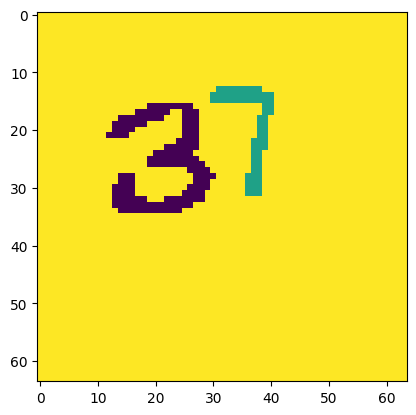

In [ ]:
fig, ax = plt.subplots()
ax.imshow(first_seg)
plt.show()

In [ ]:
print(first_seg)
print('\n')
unique, counts = np.unique(first_seg, return_counts=True)

print('Unique number of first segmentation: ', unique)
print('Occurences of unique numbers: ', counts)

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


Unique number of first segmentation:  [ 3  7 10]
Occurences of unique numbers:  [ 158   68 3870]


### Notes

We want to use Yolov5 model, which currently does not support mask format. We use supervision library to convert from mask to polygon format.


In [ ]:
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 2.6 MB/s eta 0:00:00


## Model: Yolov5s

### Step 1: .npy data

Concatenate the label with the modified polygon coordinates

### Why numpy?

There are 50000 training images so if we train Yolov5 model in Colab directly on these images, we will face with the bottleneck issue.



In [ ]:
import supervision as sv

# Load the train set
train_X = np.load("./Solutions/data/train_X.npy")
train_Y = np.load("./Solutions/data/train_Y.npy")
train_seg = np.load("./Solutions/data/train_seg.npy")

train_Y = train_Y.reshape(-1, 2, 1)
train_seg = train_seg.reshape(-1, 1, 64*64)
train_seg = np.repeat(train_seg, 2, axis=1)

# Create a mask (binary) for each label and each image
train_mask = (train_seg == train_Y).reshape(-1, 2, 64, 64)

modified_train_Y = np.empty((train_Y.shape[0], 2), dtype=object)
for i in range(len(train_mask)):
    arr = []
    for j in range(len(train_mask[i])):
        # Convert from mask to polygons
        mask = sv.mask_to_polygons(train_mask[i][j])

        # Normalize the polygon coordinates
        mask = mask[0].flatten() / 64

        # Save the result for each image
        arr.append(np.concatenate([train_Y[i][j] , mask]).tolist())
        modified_train_Y[i, j] = np.concatenate([train_Y[i][j] , mask])

# Save the numpy file
np.save('./datasets/custom-seg/images/train/train_X.npy', train_X)
np.save('./datasets/custom-seg/labels/train/train_Y.npy', modified_train_Y)


# Load the validation file
valid_X = np.load("./Solutions/data/valid_X.npy")
valid_Y = np.load("./Solutions/data/valid_Y.npy")
valid_seg = np.load("./Solutions/data/valid_seg.npy")

valid_Y = valid_Y.reshape(-1, 2, 1)
valid_seg = valid_seg.reshape(-1, 1, 64*64)
valid_seg = np.repeat(valid_seg, 2, axis = 1)

# Create a mask (binary) for each label and each image
valid_mask = (valid_seg == valid_Y).reshape(-1, 2, 64, 64)

modified_valid_Y = np.empty((valid_Y.shape[0], 2), dtype=object)
for i in range(len(valid_mask)):
    arr = []
    for j in range(len(valid_mask[i])):
        # Convert from mask to polygons
        mask = sv.mask_to_polygons(valid_mask[i][j])

        # Normalize the polygon coordinates
        mask = mask[0].flatten() / 64

        # Save the result for each image
        arr.append(np.concatenate([valid_Y[i][j] , mask]).tolist())
        modified_valid_Y[i, j] = np.concatenate([valid_Y[i][j] , mask])

# Save the numpy file
np.save('./datasets/custom-seg/images/valid/valid_X.npy', valid_X)
np.save('./datasets/custom-seg/labels/valid/valid_Y.npy',modified_valid_Y)

### Step 2: Datasets directory:

Similar to above

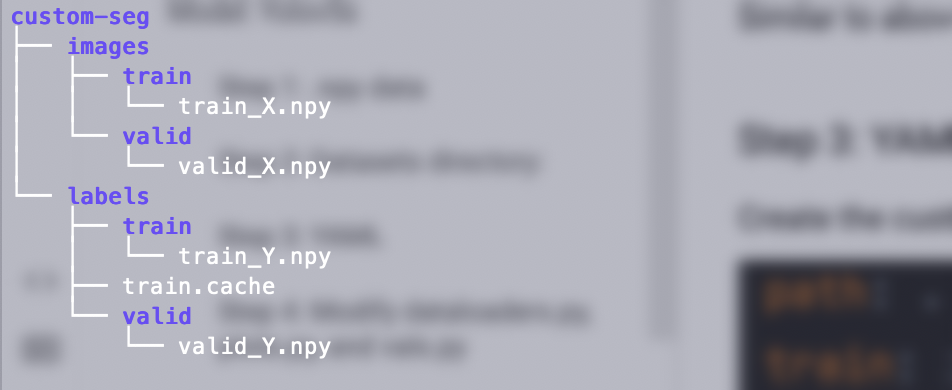

### Step 3: YAML

Create the custom-seg.yaml and put it into yolov5/data folder

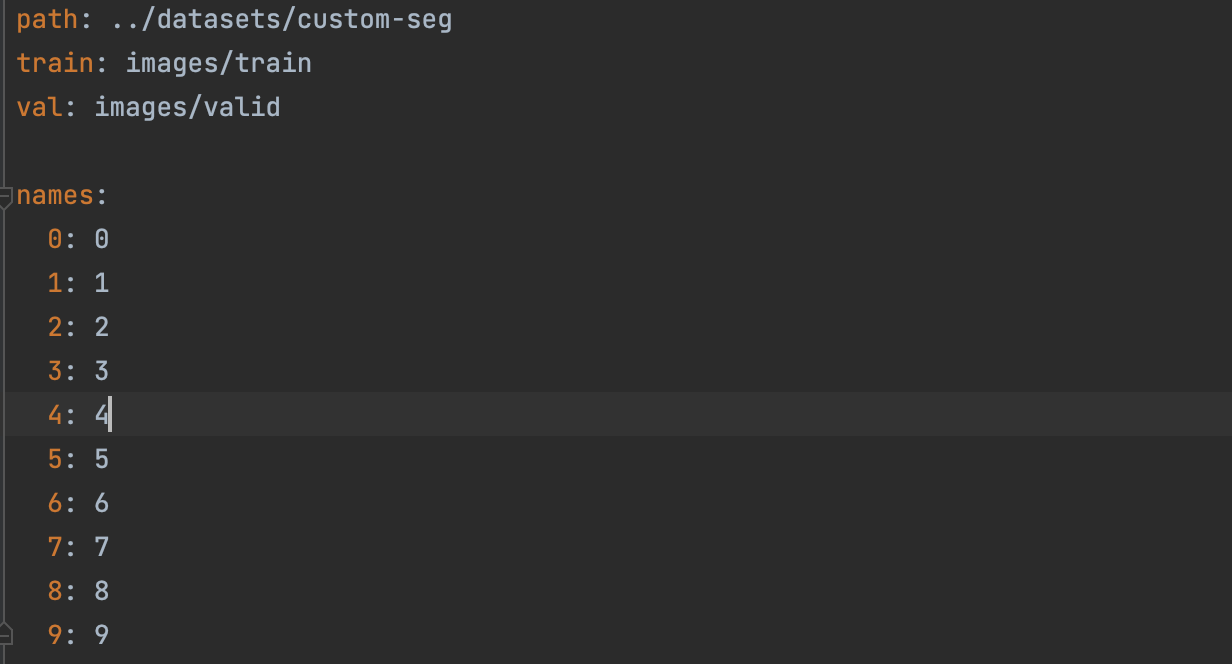

### Step 4: Modify dataloaders.py, plots.py, and vals.py

The original model DOES NOT accept .npy. Therefore, we need to modify dataloaders.py, plots.py and vals.py. Copy the following code to the appropriate files. Note that we will modify in the segments folder

In [ ]:
# Updates utils/segment/dataloaders.py
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Dataloaders
"""

import os
import random

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, distributed

from ..augmentations import augment_hsv, copy_paste, letterbox
from ..dataloaders import InfiniteDataLoader, LoadImagesAndLabels, seed_worker
from ..general import LOGGER, xyn2xy, xywhn2xyxy, xyxy2xywhn
from ..torch_utils import torch_distributed_zero_first
from .augmentations import mixup, random_perspective

RANK = int(os.getenv('RANK', -1))


def create_dataloader(path,
                      imgsz,
                      batch_size,
                      stride,
                      single_cls=False,
                      hyp=None,
                      augment=False,
                      cache=False,
                      pad=0.0,
                      rect=False,
                      rank=-1,
                      workers=8,
                      image_weights=False,
                      quad=False,
                      prefix='',
                      shuffle=False,
                      mask_downsample_ratio=1,
                      overlap_mask=False,
                      seed=0):
    if rect and shuffle:
        LOGGER.warning('WARNING ⚠️ --rect is incompatible with DataLoader shuffle, setting shuffle=False')
        shuffle = False
    with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
        dataset = LoadImagesAndLabelsAndMasks(
            path,
            imgsz,
            batch_size,
            augment=augment,  # augmentation
            hyp=hyp,  # hyperparameters
            rect=rect,  # rectangular batches
            cache_images=cache,
            single_cls=single_cls,
            stride=int(stride),
            pad=pad,
            image_weights=image_weights,
            prefix=prefix,
            downsample_ratio=mask_downsample_ratio,
            overlap=overlap_mask)

    batch_size = min(batch_size, len(dataset))
    nd = torch.cuda.device_count()  # number of CUDA devices
    nw = min([os.cpu_count() // max(nd, 1), batch_size if batch_size > 1 else 0, workers])  # number of workers
    sampler = None if rank == -1 else distributed.DistributedSampler(dataset, shuffle=shuffle)
    loader = DataLoader if image_weights else InfiniteDataLoader  # only DataLoader allows for attribute updates
    generator = torch.Generator()
    generator.manual_seed(6148914691236517205 + seed + RANK)
    return loader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle and sampler is None,
        num_workers=nw,
        sampler=sampler,
        pin_memory=True,
        collate_fn=LoadImagesAndLabelsAndMasks.collate_fn4 if quad else LoadImagesAndLabelsAndMasks.collate_fn,
        worker_init_fn=seed_worker,
        generator=generator,
    ), dataset


class LoadImagesAndLabelsAndMasks(LoadImagesAndLabels):  # for training/testing

    def __init__(
        self,
        path,
        img_size=640,
        batch_size=16,
        augment=False,
        hyp=None,
        rect=False,
        image_weights=False,
        cache_images=False,
        single_cls=False,
        stride=32,
        pad=0,
        min_items=0,
        prefix='',
        downsample_ratio=1,
        overlap=False,
    ):
        super().__init__(path, img_size, batch_size, augment, hyp, rect, image_weights, cache_images, single_cls,
                         stride, pad, min_items, prefix)
        self.downsample_ratio = downsample_ratio
        self.overlap = overlap

    def __getitem__(self, index):
        index = self.indices[index]  # linear, shuffled, or image_weights

        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        masks = []
        if mosaic:
            # Load mosaic
            img, labels, segments = self.load_mosaic(index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels, segments = mixup(img, labels, segments, *self.load_mosaic(random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = self.load_image(index)

            # Letterbox
            shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            labels = self.labels[index].copy()
            # [array, array, ....], array.shape=(num_points, 2), xyxyxyxy
            segments = self.segments[index].copy()
            if len(segments):
                for i_s in range(len(segments)):
                    segments[i_s] = xyn2xy(
                        segments[i_s],
                        ratio[0] * w,
                        ratio[1] * h,
                        padw=pad[0],
                        padh=pad[1],
                    )
            if labels.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])

            if self.augment:
                img, labels, segments = random_perspective(img,
                                                           labels,
                                                           segments=segments,
                                                           degrees=hyp['degrees'],
                                                           translate=hyp['translate'],
                                                           scale=hyp['scale'],
                                                           shear=hyp['shear'],
                                                           perspective=hyp['perspective'])

        nl = len(labels)  # number of labels
        if nl:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0], clip=True, eps=1e-3)
            if self.overlap:
                masks, sorted_idx = polygons2masks_overlap(img.shape[:2],
                                                           segments,
                                                           downsample_ratio=self.downsample_ratio)
                masks = masks[None]  # (640, 640) -> (1, 640, 640)
                labels = labels[sorted_idx]
            else:
                masks = polygons2masks(img.shape[:2], segments, color=1, downsample_ratio=self.downsample_ratio)

        masks = (torch.from_numpy(masks) if len(masks) else torch.zeros(1 if self.overlap else nl, img.shape[0] //
                                                                        self.downsample_ratio, img.shape[1] //
                                                                        self.downsample_ratio))
        # TODO: albumentations support
        if self.augment:
            # Albumentations
            # there are some augmentation that won't change boxes and masks,
            # so just be it for now.
            img, labels = self.albumentations(img, labels)
            nl = len(labels)  # update after albumentations

            # HSV color-space
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]
                    masks = torch.flip(masks, dims=[1])

            # Flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]
                    masks = torch.flip(masks, dims=[2])

            # Cutouts  # labels = cutout(img, labels, p=0.5)

        labels_out = torch.zeros((nl, 6))
        if nl:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return (torch.from_numpy(img), labels_out, self.im_files[index], shapes, masks)

    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4, segments4 = [], []
        s = self.img_size
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border)  # mosaic center x, y

        # 3 additional image indices
        indices = [index] + random.choices(self.indices, k=3)  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            labels, segments = self.labels[index].copy(), self.segments[index].copy()

            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padw, padh) for x in segments]

            labels4.append(labels)
            segments4.extend(segments)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, 1:], *segments4):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate

        # Augment
        img4, labels4, segments4 = copy_paste(img4, labels4, segments4, p=self.hyp['copy_paste'])
        img4, labels4, segments4 = random_perspective(img4,
                                                      labels4,
                                                      segments4,
                                                      degrees=self.hyp['degrees'],
                                                      translate=self.hyp['translate'],
                                                      scale=self.hyp['scale'],
                                                      shear=self.hyp['shear'],
                                                      perspective=self.hyp['perspective'],
                                                      border=self.mosaic_border)  # border to remove
        return img4, labels4, segments4

    @staticmethod
    def collate_fn(batch):
        img, label, path, shapes, masks = zip(*batch)  # transposed
        batched_masks = torch.cat(masks, 0)
        for i, l in enumerate(label):
            l[:, 0] = i  # add target image index for build_targets()
        return torch.stack(img, 0), torch.cat(label, 0), path, shapes, batched_masks


def polygon2mask(img_size, polygons, color=1, downsample_ratio=1):
    """
    Args:
        img_size (tuple): The image size.
        polygons (np.ndarray): [N, M], N is the number of polygons,
            M is the number of points(Be divided by 2).
    """
    mask = np.zeros(img_size, dtype=np.uint8)
    polygons = np.asarray(polygons)
    polygons = polygons.astype(np.int32)
    shape = polygons.shape
    polygons = polygons.reshape(shape[0], -1, 2)
    cv2.fillPoly(mask, polygons, color=color)
    nh, nw = (img_size[0] // downsample_ratio, img_size[1] // downsample_ratio)
    # NOTE: fillPoly firstly then resize is trying the keep the same way
    # of loss calculation when mask-ratio=1.
    mask = cv2.resize(mask, (nw, nh))
    return mask


def polygons2masks(img_size, polygons, color, downsample_ratio=1):
    """
    Args:
        img_size (tuple): The image size.
        polygons (list[np.ndarray]): each polygon is [N, M],
            N is the number of polygons,
            M is the number of points(Be divided by 2).
    """
    masks = []
    for si in range(len(polygons)):
        mask = polygon2mask(img_size, [polygons[si].reshape(-1)], color, downsample_ratio)
        masks.append(mask)
    return np.array(masks)


def polygons2masks_overlap(img_size, segments, downsample_ratio=1):
    """Return a (640, 640) overlap mask."""
    masks = np.zeros((img_size[0] // downsample_ratio, img_size[1] // downsample_ratio),
                     dtype=np.int32 if len(segments) > 255 else np.uint8)
    areas = []
    ms = []
    for si in range(len(segments)):
        mask = polygon2mask(
            img_size,
            [segments[si].reshape(-1)],
            downsample_ratio=downsample_ratio,
            color=1,
        )
        ms.append(mask)
        areas.append(mask.sum())
    areas = np.asarray(areas)
    index = np.argsort(-areas)
    ms = np.array(ms)[index]
    for i in range(len(segments)):
        mask = ms[i] * (i + 1)
        masks = masks + mask
        masks = np.clip(masks, a_min=0, a_max=i + 1)
    return masks, index


In [ ]:
# Updates utils/segment/plots.py
import contextlib
import math
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from .. import threaded
from ..general import xywh2xyxy
from ..plots import Annotator, colors


@threaded
def plot_images_and_masks(images, targets, masks, paths=None, fname='images.jpg', names=None):
    # Plot image grid with labels
    if isinstance(images, torch.Tensor):
        images = images.cpu().float().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    if isinstance(masks, torch.Tensor):
        masks = masks.cpu().numpy().astype(int)

    max_size = 1920  # max image size
    max_subplots = 16  # max image subplots, i.e. 4x4
    bs, _, h, w = images.shape  # batch size, _, height, width
    bs = min(bs, max_subplots)  # limit plot images
    ns = np.ceil(bs ** 0.5)  # number of subplots (square)
    if np.max(images[0]) <= 1:
        images *= 255  # de-normalise (optional)

    # Build Image
    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)  # init
    for i, im in enumerate(images):
        if i == max_subplots:  # if last batch has fewer images than we expect
            break
        x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
        im = im.transpose(1, 2, 0)
        mosaic[y:y + h, x:x + w, :] = im

    # Resize (optional)
    scale = max_size / ns / max(h, w)
    if scale < 1:
        h = math.ceil(scale * h)
        w = math.ceil(scale * w)
        mosaic = cv2.resize(mosaic, tuple(int(x * ns) for x in (w, h)))

    # Annotate
    fs = int((h + w) * ns * 0.01)  # font size
    annotator = Annotator(mosaic, line_width=round(fs / 10), font_size=fs, pil=True, example=names)
    for i in range(i + 1):
        x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
        annotator.rectangle([x, y, x + w, y + h], None, (255, 255, 255), width=2)  # borders
        if paths:
            if type(paths[i]) == np.ndarray:
                annotator.text([x + 5, y + 5], text=str(i), txt_color=(220, 220, 220))  # filenames

            else:
                annotator.text([x + 5, y + 5], text=Path(paths[i]).name[:40], txt_color=(220, 220, 220))  # filenames
        if len(targets) > 0:
            idx = targets[:, 0] == i
            ti = targets[idx]  # image targets

            boxes = xywh2xyxy(ti[:, 2:6]).T
            classes = ti[:, 1].astype('int')
            labels = ti.shape[1] == 6  # labels if no conf column
            conf = None if labels else ti[:, 6]  # check for confidence presence (label vs pred)

            if boxes.shape[1]:
                if boxes.max() <= 1.01:  # if normalized with tolerance 0.01
                    boxes[[0, 2]] *= w  # scale to pixels
                    boxes[[1, 3]] *= h
                elif scale < 1:  # absolute coords need scale if image scales
                    boxes *= scale
            boxes[[0, 2]] += x
            boxes[[1, 3]] += y
            for j, box in enumerate(boxes.T.tolist()):
                cls = classes[j]
                color = colors(cls)
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.25:  # 0.25 conf thresh
                    label = f'{cls}' if labels else f'{cls} {conf[j]:.1f}'
                    annotator.box_label(box, label, color=color)

            # Plot masks
            if len(masks):
                if masks.max() > 1.0:  # mean that masks are overlap
                    image_masks = masks[[i]]  # (1, 640, 640)
                    nl = len(ti)
                    index = np.arange(nl).reshape(nl, 1, 1) + 1
                    image_masks = np.repeat(image_masks, nl, axis=0)
                    image_masks = np.where(image_masks == index, 1.0, 0.0)
                else:
                    image_masks = masks[idx]

                im = np.asarray(annotator.im).copy()
                for j, box in enumerate(boxes.T.tolist()):
                    if labels or conf[j] > 0.25:  # 0.25 conf thresh
                        color = colors(classes[j])
                        mh, mw = image_masks[j].shape
                        if mh != h or mw != w:
                            mask = image_masks[j].astype(np.uint8)
                            mask = cv2.resize(mask, (w, h))
                            mask = mask.astype(bool)
                        else:
                            mask = image_masks[j].astype(bool)
                        with contextlib.suppress(Exception):
                            im[y:y + h, x:x + w, :][mask] = im[y:y + h, x:x + w, :][mask] * 0.4 + np.array(color) * 0.6
                annotator.fromarray(im)
    annotator.im.save(fname)  # save


def plot_results_with_masks(file='path/to/results.csv', dir='', best=True):
    # Plot training results.csv. Usage: from utils.plots import *; plot_results('path/to/results.csv')
    save_dir = Path(file).parent if file else Path(dir)
    fig, ax = plt.subplots(2, 8, figsize=(18, 6), tight_layout=True)
    ax = ax.ravel()
    files = list(save_dir.glob('results*.csv'))
    assert len(files), f'No results.csv files found in {save_dir.resolve()}, nothing to plot.'
    for f in files:
        try:
            data = pd.read_csv(f)
            index = np.argmax(0.9 * data.values[:, 8] + 0.1 * data.values[:, 7] + 0.9 * data.values[:, 12] +
                              0.1 * data.values[:, 11])
            s = [x.strip() for x in data.columns]
            x = data.values[:, 0]
            for i, j in enumerate([1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 16, 7, 8, 11, 12]):
                y = data.values[:, j]
                # y[y == 0] = np.nan  # don't show zero values
                ax[i].plot(x, y, marker='.', label=f.stem, linewidth=2, markersize=2)
                if best:
                    # best
                    ax[i].scatter(index, y[index], color='r', label=f'best:{index}', marker='*', linewidth=3)
                    ax[i].set_title(s[j] + f'\n{round(y[index], 5)}')
                else:
                    # last
                    ax[i].scatter(x[-1], y[-1], color='r', label='last', marker='*', linewidth=3)
                    ax[i].set_title(s[j] + f'\n{round(y[-1], 5)}')
                # if j in [8, 9, 10]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            print(f'Warning: Plotting error for {f}: {e}')
    ax[1].legend()
    fig.savefig(save_dir / 'results.png', dpi=200)
    plt.close()


In [ ]:
# Updates segment/val.py
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Validate a trained YOLOv5 segment model on a segment dataset

Usage:
    $ bash data/scripts/get_coco.sh --val --segments  # download COCO-segments val split (1G, 5000 images)
    $ python segment/val.py --weights yolov5s-seg.pt --data coco.yaml --img 640  # validate COCO-segments

Usage - formats:
    $ python segment/val.py --weights yolov5s-seg.pt                 # PyTorch
                                      yolov5s-seg.torchscript        # TorchScript
                                      yolov5s-seg.onnx               # ONNX Runtime or OpenCV DNN with --dnn
                                      yolov5s-seg_openvino_label     # OpenVINO
                                      yolov5s-seg.engine             # TensorRT
                                      yolov5s-seg.mlmodel            # CoreML (macOS-only)
                                      yolov5s-seg_saved_model        # TensorFlow SavedModel
                                      yolov5s-seg.pb                 # TensorFlow GraphDef
                                      yolov5s-seg.tflite             # TensorFlow Lite
                                      yolov5s-seg_edgetpu.tflite     # TensorFlow Edge TPU
                                      yolov5s-seg_paddle_model       # PaddlePaddle
"""

import argparse
import json
import os
import subprocess
import sys
from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import torch
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[1]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import torch.nn.functional as F

from models.common import DetectMultiBackend
from models.yolo import SegmentationModel
from utils.callbacks import Callbacks
from utils.general import (LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, Profile, check_dataset, check_img_size,
                           check_requirements, check_yaml, coco80_to_coco91_class, colorstr, increment_path,
                           non_max_suppression, print_args, scale_boxes, xywh2xyxy, xyxy2xywh)
from utils.metrics import ConfusionMatrix, box_iou
from utils.plots import output_to_target, plot_val_study
from utils.segment.dataloaders import create_dataloader
from utils.segment.general import mask_iou, process_mask, process_mask_native, scale_image
from utils.segment.metrics import Metrics, ap_per_class_box_and_mask
from utils.segment.plots import plot_images_and_masks
from utils.torch_utils import de_parallel, select_device, smart_inference_mode


def save_one_txt(predn, save_conf, shape, file):
    # Save one txt result
    gn = torch.tensor(shape)[[1, 0, 1, 0]]  # normalization gain whwh
    for *xyxy, conf, cls in predn.tolist():
        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
        with open(file, 'a') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')


def save_one_json(predn, jdict, path, class_map, pred_masks):
    # Save one JSON result {"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}
    from pycocotools.mask import encode

    def single_encode(x):
        rle = encode(np.asarray(x[:, :, None], order='F', dtype='uint8'))[0]
        rle['counts'] = rle['counts'].decode('utf-8')
        return rle

    image_id = int(path.stem) if path.stem.isnumeric() else path.stem
    box = xyxy2xywh(predn[:, :4])  # xywh
    box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
    pred_masks = np.transpose(pred_masks, (2, 0, 1))
    with ThreadPool(NUM_THREADS) as pool:
        rles = pool.map(single_encode, pred_masks)
    for i, (p, b) in enumerate(zip(predn.tolist(), box.tolist())):
        jdict.append({
            'image_id': image_id,
            'category_id': class_map[int(p[5])],
            'bbox': [round(x, 3) for x in b],
            'score': round(p[4], 5),
            'segmentation': rles[i]})


def process_batch(detections, labels, iouv, pred_masks=None, gt_masks=None, overlap=False, masks=False):
    """
    Return correct prediction matrix
    Arguments:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class
        labels (array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    if masks:
        if overlap:
            nl = len(labels)
            index = torch.arange(nl, device=gt_masks.device).view(nl, 1, 1) + 1
            gt_masks = gt_masks.repeat(nl, 1, 1)  # shape(1,640,640) -> (n,640,640)
            gt_masks = torch.where(gt_masks == index, 1.0, 0.0)
        if gt_masks.shape[1:] != pred_masks.shape[1:]:
            gt_masks = F.interpolate(gt_masks[None], pred_masks.shape[1:], mode='bilinear', align_corners=False)[0]
            gt_masks = gt_masks.gt_(0.5)
        iou = mask_iou(gt_masks.view(gt_masks.shape[0], -1), pred_masks.view(pred_masks.shape[0], -1))
    else:  # boxes
        iou = box_iou(labels[:, 1:], detections[:, :4])

    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)


@smart_inference_mode()
def run(
        data,
        weights=None,  # model.pt path(s)
        batch_size=32,  # batch size
        imgsz=640,  # inference size (pixels)
        conf_thres=0.001,  # confidence threshold
        iou_thres=0.6,  # NMS IoU threshold
        max_det=300,  # maximum detections per image
        task='val',  # train, val, test, speed or study
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        workers=8,  # max dataloader workers (per RANK in DDP mode)
        single_cls=False,  # treat as single-class dataset
        augment=False,  # augmented inference
        verbose=False,  # verbose output
        save_txt=False,  # save results to *.txt
        save_hybrid=False,  # save label+prediction hybrid results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_json=False,  # save a COCO-JSON results file
        project=ROOT / 'runs/val-seg',  # save to project/name
        name='exp',  # save to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        half=True,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        model=None,
        dataloader=None,
        save_dir=Path(''),
        plots=True,
        overlap=False,
        mask_downsample_ratio=1,
        compute_loss=None,
        callbacks=Callbacks(),
):
    if save_json:
        check_requirements('pycocotools>=2.0.6')
        process = process_mask_native  # more accurate
    else:
        process = process_mask  # faster

    # Initialize/load model and set device
    training = model is not None
    if training:  # called by train.py
        device, pt, jit, engine = next(model.parameters()).device, True, False, False  # get model device, PyTorch model
        half &= device.type != 'cpu'  # half precision only supported on CUDA
        model.half() if half else model.float()
        nm = de_parallel(model).model[-1].nm  # number of masks
    else:  # called directly
        device = select_device(device, batch_size=batch_size)

        # Directories
        save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
        (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

        # Load model
        model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
        stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
        imgsz = check_img_size(imgsz, s=stride)  # check image size
        half = model.fp16  # FP16 supported on limited backends with CUDA
        nm = de_parallel(model).model.model[-1].nm if isinstance(model, SegmentationModel) else 32  # number of masks
        if engine:
            batch_size = model.batch_size
        else:
            device = model.device
            if not (pt or jit):
                batch_size = 1  # export.py models default to batch-size 1
                LOGGER.info(f'Forcing --batch-size 1 square inference (1,3,{imgsz},{imgsz}) for non-PyTorch models')

        # Data
        data = check_dataset(data)  # check

    # Configure
    model.eval()
    cuda = device.type != 'cpu'
    is_coco = isinstance(data.get('val'), str) and data['val'].endswith(f'coco{os.sep}val2017.txt')  # COCO dataset
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if not training:
        if pt and not single_cls:  # check --weights are trained on --data
            ncm = model.model.nc
            assert ncm == nc, f'{weights} ({ncm} classes) trained on different --data than what you passed ({nc} ' \
                              f'classes). Pass correct combination of --weights and --data that are trained together.'
        model.warmup(imgsz=(1 if pt else batch_size, 3, imgsz, imgsz))  # warmup
        pad, rect = (0.0, False) if task == 'speed' else (0.5, pt)  # square inference for benchmarks
        task = task if task in ('train', 'val', 'test') else 'val'  # path to train/val/test images
        dataloader = create_dataloader(data[task],
                                       imgsz,
                                       batch_size,
                                       stride,
                                       single_cls,
                                       pad=pad,
                                       rect=rect,
                                       workers=workers,
                                       prefix=colorstr(f'{task}: '),
                                       overlap_mask=overlap,
                                       mask_downsample_ratio=mask_downsample_ratio)[0]

    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    names = model.names if hasattr(model, 'names') else model.module.names  # get class names
    if isinstance(names, (list, tuple)):  # old format
        names = dict(enumerate(names))
    class_map = coco80_to_coco91_class() if is_coco else list(range(1000))
    s = ('%22s' + '%11s' * 10) % ('Class', 'Images', 'Instances', 'Box(P', 'R', 'mAP50', 'mAP50-95)', 'Mask(P', 'R',
                                  'mAP50', 'mAP50-95)')
    dt = Profile(), Profile(), Profile()
    metrics = Metrics()
    loss = torch.zeros(4, device=device)
    jdict, stats = [], []
    # callbacks.run('on_val_start')
    pbar = tqdm(dataloader, desc=s, bar_format=TQDM_BAR_FORMAT)  # progress bar
    for batch_i, (im, targets, paths, shapes, masks) in enumerate(pbar):
        # callbacks.run('on_val_batch_start')
        with dt[0]:
            if cuda:
                im = im.to(device, non_blocking=True)
                targets = targets.to(device)
                masks = masks.to(device)
            masks = masks.float()
            im = im.half() if half else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            nb, _, height, width = im.shape  # batch size, channels, height, width

        # Inference
        with dt[1]:
            preds, protos, train_out = model(im) if compute_loss else (*model(im, augment=augment)[:2], None)

        # Loss
        if compute_loss:
            loss += compute_loss((train_out, protos), targets, masks)[1]  # box, obj, cls

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height), device=device)  # to pixels
        lb = [targets[targets[:, 0] == i, 1:] for i in range(nb)] if save_hybrid else []  # for autolabelling
        with dt[2]:
            preds = non_max_suppression(preds,
                                        conf_thres,
                                        iou_thres,
                                        labels=lb,
                                        multi_label=True,
                                        agnostic=single_cls,
                                        max_det=max_det,
                                        nm=nm)

        # Metrics
        plot_masks = []  # masks for plotting
        for si, (pred, proto) in enumerate(zip(preds, protos)):
            labels = targets[targets[:, 0] == si, 1:]
            nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
            if type(paths[si]) == np.ndarray:
                path, shape = paths[si], shapes[si][0]
            else:
                path, shape = Path(paths[si]), shapes[si][0]
            correct_masks = torch.zeros(npr, niou, dtype=torch.bool, device=device)  # init
            correct_bboxes = torch.zeros(npr, niou, dtype=torch.bool, device=device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    stats.append((correct_masks, correct_bboxes, *torch.zeros((2, 0), device=device), labels[:, 0]))
                    if plots:
                        confusion_matrix.process_batch(detections=None, labels=labels[:, 0])
                continue

            # Masks
            midx = [si] if overlap else targets[:, 0] == si
            gt_masks = masks[midx]
            pred_masks = process(proto, pred[:, 6:], pred[:, :4], shape=im[si].shape[1:])

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct_bboxes = process_batch(predn, labelsn, iouv)
                correct_masks = process_batch(predn, labelsn, iouv, pred_masks, gt_masks, overlap=overlap, masks=True)
                if plots:
                    confusion_matrix.process_batch(predn, labelsn)
            stats.append((correct_masks, correct_bboxes, pred[:, 4], pred[:, 5], labels[:, 0]))  # (conf, pcls, tcls)

            pred_masks = torch.as_tensor(pred_masks, dtype=torch.uint8)
            if plots and batch_i < 3:
                plot_masks.append(pred_masks[:15])  # filter top 15 to plot

            # Save/log
            if save_txt:
                save_one_txt(predn, save_conf, shape, file=save_dir / 'labels' / f'{path.stem}.txt')
            if save_json:
                pred_masks = scale_image(im[si].shape[1:],
                                         pred_masks.permute(1, 2, 0).contiguous().cpu().numpy(), shape, shapes[si][1])
                save_one_json(predn, jdict, path, class_map, pred_masks)  # append to COCO-JSON dictionary
            # callbacks.run('on_val_image_end', pred, predn, path, names, im[si])

        # Plot images
        if plots and batch_i < 3:
            if len(plot_masks):
                plot_masks = torch.cat(plot_masks, dim=0)
            plot_images_and_masks(im, targets, masks, paths, save_dir / f'val_batch{batch_i}_labels.jpg', names)
            plot_images_and_masks(im, output_to_target(preds, max_det=15), plot_masks, paths,
                                  save_dir / f'val_batch{batch_i}_pred.jpg', names)  # pred

        # callbacks.run('on_val_batch_end')

    # Compute metrics
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        results = ap_per_class_box_and_mask(*stats, plot=plots, save_dir=save_dir, names=names)
        metrics.update(results)
    nt = np.bincount(stats[4].astype(int), minlength=nc)  # number of targets per class

    # Print results
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 8  # print format
    LOGGER.info(pf % ('all', seen, nt.sum(), *metrics.mean_results()))
    if nt.sum() == 0:
        LOGGER.warning(f'WARNING ⚠️ no labels found in {task} set, can not compute metrics without labels')

    # Print results per class
    if (verbose or (nc < 50 and not training)) and nc > 1 and len(stats):
        for i, c in enumerate(metrics.ap_class_index):
            LOGGER.info(pf % (names[c], seen, nt[c], *metrics.class_result(i)))

    # Print speeds
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
    if not training:
        shape = (batch_size, 3, imgsz, imgsz)
        LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {shape}' % t)

    # Plots
    if plots:
        confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))
    # callbacks.run('on_val_end')

    mp_bbox, mr_bbox, map50_bbox, map_bbox, mp_mask, mr_mask, map50_mask, map_mask = metrics.mean_results()

    # Save JSON
    if save_json and len(jdict):
        w = Path(weights[0] if isinstance(weights, list) else weights).stem if weights is not None else ''  # weights
        anno_json = str(Path('../datasets/coco/annotations/instances_val2017.json'))  # annotations
        pred_json = str(save_dir / f'{w}_predictions.json')  # predictions
        LOGGER.info(f'\nEvaluating pycocotools mAP... saving {pred_json}...')
        with open(pred_json, 'w') as f:
            json.dump(jdict, f)

        try:  # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
            from pycocotools.coco import COCO
            from pycocotools.cocoeval import COCOeval

            anno = COCO(anno_json)  # init annotations api
            pred = anno.loadRes(pred_json)  # init predictions api
            results = []
            for eval in COCOeval(anno, pred, 'bbox'), COCOeval(anno, pred, 'segm'):
                if is_coco:
                    eval.params.imgIds = [int(Path(x).stem) for x in dataloader.dataset.im_files]  # img ID to evaluate
                eval.evaluate()
                eval.accumulate()
                eval.summarize()
                results.extend(eval.stats[:2])  # update results (mAP@0.5:0.95, mAP@0.5)
            map_bbox, map50_bbox, map_mask, map50_mask = results
        except Exception as e:
            LOGGER.info(f'pycocotools unable to run: {e}')

    # Return results
    model.float()  # for training
    if not training:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    final_metric = mp_bbox, mr_bbox, map50_bbox, map_bbox, mp_mask, mr_mask, map50_mask, map_mask
    return (*final_metric, *(loss.cpu() / len(dataloader)).tolist()), metrics.get_maps(nc), t


def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128-seg.yaml', help='dataset.yaml path')
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'yolov5s-seg.pt', help='model path(s)')
    parser.add_argument('--batch-size', type=int, default=32, help='batch size')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.001, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.6, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=300, help='maximum detections per image')
    parser.add_argument('--task', default='val', help='train, val, test, speed or study')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--workers', type=int, default=8, help='max dataloader workers (per RANK in DDP mode)')
    parser.add_argument('--single-cls', action='store_true', help='treat as single-class dataset')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--verbose', action='store_true', help='report mAP by class')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-hybrid', action='store_true', help='save label+prediction hybrid results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-json', action='store_true', help='save a COCO-JSON results file')
    parser.add_argument('--project', default=ROOT / 'runs/val-seg', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    opt = parser.parse_args()
    opt.data = check_yaml(opt.data)  # check YAML
    # opt.save_json |= opt.data.endswith('coco.yaml')
    opt.save_txt |= opt.save_hybrid
    print_args(vars(opt))
    return opt


def main(opt):
    check_requirements(ROOT / 'requirements.txt', exclude=('tensorboard', 'thop'))

    if opt.task in ('train', 'val', 'test'):  # run normally
        if opt.conf_thres > 0.001:  # https://github.com/ultralytics/yolov5/issues/1466
            LOGGER.warning(f'WARNING ⚠️ confidence threshold {opt.conf_thres} > 0.001 produces invalid results')
        if opt.save_hybrid:
            LOGGER.warning('WARNING ⚠️ --save-hybrid returns high mAP from hybrid labels, not from predictions alone')
        run(**vars(opt))

    else:
        weights = opt.weights if isinstance(opt.weights, list) else [opt.weights]
        opt.half = torch.cuda.is_available() and opt.device != 'cpu'  # FP16 for fastest results
        if opt.task == 'speed':  # speed benchmarks
            # python val.py --task speed --data coco.yaml --batch 1 --weights yolov5n.pt yolov5s.pt...
            opt.conf_thres, opt.iou_thres, opt.save_json = 0.25, 0.45, False
            for opt.weights in weights:
                run(**vars(opt), plots=False)

        elif opt.task == 'study':  # speed vs mAP benchmarks
            # python val.py --task study --data coco.yaml --iou 0.7 --weights yolov5n.pt yolov5s.pt...
            for opt.weights in weights:
                f = f'study_{Path(opt.data).stem}_{Path(opt.weights).stem}.txt'  # filename to save to
                x, y = list(range(256, 1536 + 128, 128)), []  # x axis (image sizes), y axis
                for opt.imgsz in x:  # img-size
                    LOGGER.info(f'\nRunning {f} --imgsz {opt.imgsz}...')
                    r, _, t = run(**vars(opt), plots=False)
                    y.append(r + t)  # results and times
                np.savetxt(f, y, fmt='%10.4g')  # save
            subprocess.run(['zip', '-r', 'study.zip', 'study_*.txt'])
            plot_val_study(x=x)  # plot
        else:
            raise NotImplementedError(f'--task {opt.task} not in ("train", "val", "test", "speed", "study")')


if __name__ == '__main__':
    opt = parse_opt()
    main(opt)


### Step 5: Run the code

In [4]:
%cd yolov5
!python segment/train.py --img 64 --epochs 3 --data custom-seg.yaml --weights yolov5s-seg.pt

Streaming output truncated to the last 5000 lines.
train: WARNING ⚠️ [ 72   0 192 ...  72   0 192]: 1 duplicate labels removed
train: WARNING ⚠️ [48 72 48 ... 48 72 48]: 1 duplicate labels removed
train: WARNING ⚠️ [148   0 211 ... 148   0 211]: 1 duplicate labels removed
train: WARNING ⚠️ [144 216  96 ... 144 216  96]: 1 duplicate labels removed
train: WARNING ⚠️ [120 144 216 ... 120 144 216]: 1 duplicate labels removed
train: WARNING ⚠️ [ 48 240  24 ...  48 240  24]: 1 duplicate labels removed
train: WARNING ⚠️ [  0 240  24 ...   0 240  24]: 1 duplicate labels removed
train: WARNING ⚠️ [ 24   0 168 ...  24   0 168]: 1 duplicate labels removed
train: WARNING ⚠️ [192  24 144 ... 192  24 144]: 1 duplicate labels removed
train: WARNING ⚠️ [  0 216 168 ...   0 216 168]: 1 duplicate labels removed
train: WARNING ⚠️ [168 192  96 ... 168 192  96]: 1 duplicate labels removed
train: WARNING ⚠️ [216   0 168 ... 216   0 168]: 1 duplicate labels removed
train: WARNING ⚠️ [144  24 168 ... 144  24 

# Reference

- [Object segmentation format converter](https://colab.research.google.com/drive/1Q6eio7xlgECcnbrgwHdanXJ850JVRzk3?usp=sharing&ref=blog.roboflow.com)
- [Object detection on custom data](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/)
- [Tips for best training result](https://docs.ultralytics.com/yolov5/tutorials/tips_for_best_training_results/#further-reading)
- [Torch hub for pretrained model](https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading/#multi-gpu-inference)

- [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)